In [1]:
import math
import torch
from torch import nn
from torch import Tensor
from torch.nn  import functional as F
import gpytorch
from matplotlib import pyplot as plt
from torch.distributions.multivariate_normal import MultivariateNormal
import matplotlib.cm as cm
import matplotlib.patches as patches
from mpl_toolkits.mplot3d import Axes3D 
import sys
from decimal import Decimal
from IPython.display import clear_output
sys.path.append("..")
from LBFGS import FullBatchLBFGS
from kernels import vvkernels as vvk, sep_vvkernels as svvk, vvk_rbfkernel as vvk_rbf
from means import vvmeans as vvm
from likelihood import vvlikelihood as vvll
from mlikelihoods import MarginalLogLikelihood as exmll
from predstrategies import GPprediction
from utils import ObjFun, get_vertices, stopping_criteria
from scipy import stats
import numpy as np
import seaborn as sns
import scipy
%matplotlib inline
%load_ext autoreload
%autoreload 2

# Single GPU is enabled

This is the ConvSuccess_homoskedatic notebook with single-GPU enabled by simply `anything.cuda()`.
It will automatically determine and use GPU if GPU is avaiblable and use CPU if it is not. To use CPU when GPU is available, simply change the line in cell [4] to `use_cuda = False`

# Plots settings

In [2]:
sns.set_style('darkgrid') # darkgrid, white grid, dark, white and ticks
plt.rc('axes', titlesize=40)     # fontsize of the axes title
plt.rc('axes', labelsize=32)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=32)    # fontsize of the tick labels
plt.rc('ytick', labelsize=32)    # fontsize of the tick labels
plt.rc('legend', fontsize=32)    # legend fontsize
plt.rc('font', size=32)          # controls default text sizes


# Objective function

We sample from $$V_1(x_1, x_2) = 3(1 - x_1)^2 e^{-x_1^2 - (x_2 +1)^2} - 10 (x_1/5 - x_1 ^3 - x_2^5) e^{-x_1^2 - x_2 ^2} - 3 e^{- (x_1 + 2) ^2 - x_2^2} + 0.5(2x_1 + x_2)$$
$$V_2(x_1, x_2) = 3(1 +x_2)^2 e^{-x_2^2 - (x_1 +1)^2} - 10 (-x_2/5 + x_2 ^3 + x_1^5) e^{-x_1^2 - x_2 ^2} - 3 e^{- ( 2- x_2) ^2 - x_1^2} + 0.5(2x_1 + x_2)$$

where $(x_1, x_2) \in [-3, 3]^2$

In [3]:
torch.set_default_dtype(torch.float64)

In [4]:
use_cuda = torch.cuda.is_available()
device = torch.device('cuda' if use_cuda else 'cpu')

vf = ObjFun()
f_target = vf.tgt_vec
print(f_target)
sample_size = 4
D = vf.D
N = vf.N

vf.low = -1.
vf.high = 1.

high_minus_low = vf.high- vf.low
#high_minus_low = -
def g_theta(sample_size, D):
#     loc_x = (2. - 1.0 )  * np.random.random_sample((sample_size,1)) + 1.0
    
#     loc_y = (2.  -1.0)  * np.random.random_sample((sample_size,1)) - 2.
#     loc = np.concatenate((loc_x, loc_y), 1)
    loc = high_minus_low  * np.random.random_sample((sample_size,2)) + vf.low#(np.random.uniform(low=vf.low, high=vf.high, size=(sample_size, D)))
    return Tensor(loc)
train_x = g_theta(sample_size, D)
if use_cuda:
    train_x = train_x.cuda()
#train_x = Tensor([[-1.5, 1.5], [-1.5, 1.3]])
print(train_x)
noise_value = 0.0004 #noise_free = 0.
def vfield_(x):
    x = x.reshape(x.shape[0],D)
    out = torch.zeros(x.shape[0], N)
    randn = torch.randn(Tensor(vf(x[:,0], x[:,1])).size())
    randn = randn.to(x.device)
    out = vf(x[:,0], x[:,1]) + randn * math.sqrt(noise_value)
    return out #/torch.max(out)

train_y = vfield_(train_x)

# print(train_y)
# train_y = (train_y - train_y.mean())/train_y.std(dim=-2, keepdim=True)
# train_x = (train_x - train_x.mean())/train_x.std(dim=-2, keepdim=True)
# print(train_y)
# print(train_y.std(dim=-2, keepdim=True))


tensor([0.3380, 0.3502], dtype=torch.float32)
tensor([[-0.1928,  0.1283],
        [ 0.4447, -0.1741],
        [-0.1037,  0.4016],
        [ 0.7826,  0.3245]], device='cuda:0')


## GP model initialization
We inialize the GP model following https://docs.gpytorch.ai/en/stable/examples/03_Multitask_Exact_GPs/Multitask_GP_Regression.html

In [5]:
x_train = train_x #loc #torch.linspace(0, 1, 10)
y_train = train_y #v  #torch.stack([torch.sin(train_x * (2 * math.pi)) + torch.randn(train_x.size()) * 0.2,torch.cos(train_x * (2 * math.pi)) + torch.randn(train_x.size()) * 0.2,], -1)

class MultitaskGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood,num_base_kernels):
        super(MultitaskGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = vvm.TensorProductSubMean(gpytorch.means.LinearMean(2), num_tasks = 2)  #vvm.TensorProductSubMean(gpytorch.means.LinearMean(2), num_tasks = 2)#vvm.TensorProductSubMean(gpytorch.means.ConstantMean(), num_tasks = 2)  # 
        base_kernels = [] #contain all the base kernels
        for i in range(num_base_kernels):
            base_kernels.append(gpytorch.kernels.ScaleKernel(( gpytorch.kernels.RBFKernel() ))) #gpytorch.kernels.PolynomialKernel(4)  ##gpytorch.kernels.MaternKernel()# (vvk_rbf.vvkRBFKernel())
 
            
        self.covar_module = svvk.SepTensorProductKernel(base_kernels,num_tasks = 2)

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultitaskMultivariateNormal(mean_x, covar_x)
    
    



# Hyperparamaters oprimization

In [6]:
# # ###hyperparameters optimization###
def hyper_opti(g_theta1, agg_data, training_iter,num_base_kernels,noise_value, current_model = None, current_likelihood = None):
    noises = torch.ones(agg_data.shape[0]) * (noise_value) #  torch.zeros(agg_data.shape[0]) # 
    noises = noises.reshape(g_theta1.shape[0], 2)
    
#     if (current_model is not None):
#         likelihood = current_likelihood #vvll.FixedNoiseMultitaskGaussianLikelihood(2, noises) #vvll.FixedNoiseMultitaskGaussianLikelihood(2, noises)  #

#         model = current_model#.get_fantasy_model(g_theta1, agg_data) #MultitaskGPModel(g_theta1, agg_data, likelihood,num_base_kernels)
#         model.set_train_data(g_theta1, agg_data,  strict=False)
#     else:
#         likelihood = vvll.FixedNoiseMultitaskGaussianLikelihood(noises) #vvll.TensorProductLikelihood(num_tasks = 2)#vvll.FixedNoiseMultitaskGaussianLikelihood(2, noises) #
#         model = MultitaskGPModel(g_theta1, agg_data, likelihood,num_base_kernels)
        
    cov_noise1 =  noise_value * torch.eye(agg_data.shape[0])
    likelihood =  vvll.FixedNoiseMultitaskGaussianLikelihood(noises) #vvll.TensorProductLikelihood(num_tasks = 2) #
    model = MultitaskGPModel(g_theta1, agg_data, likelihood,num_base_kernels)
    model.double()
    likelihood.double()

    """Put related things on GPU"""
    if use_cuda:
        print("Using CUDA")
        model = model.cuda()
        likelihood = likelihood.cuda()
#         g_theta1 = g_theta1.cuda()
#         agg_data = agg_data.cuda()
        cov_noise1 = cov_noise1.cuda()
        
    else:
        print("Using CPU")
    
    
    """end for GPU"""

    model.train()
    
    likelihood.train()

    optimizer = torch.optim.Adam(model.parameters(),  lr=0.1) #, weight_decay=0.001)  # Includes GaussianLikelihood parameters
    mll = exmll(likelihood, model)
    # Is this a likelihood?

    for i in range(training_iter):
        optimizer.zero_grad()

        loss, chi_square = mll(agg_data,g_theta1, model, likelihood, cov_noise1)
        loss = -1. * loss
#         print('df is %.3f' %agg_data.shape[0] +'and chi_square %.3f' %chi_square) 
        #print('loss is %.3f' %loss)
#         df = agg_data.shape[0]
#         chi_square = chi_square.clone().detach()
        
#         p_val = 1. - stats.chi2.cdf(chi_square, df)
        loss.backward()
        optimizer.step()
        #scheduler.step(loss)
       # print(p_val)
#         if (p_val > 0.99999):
#             return model, likelihood


    
        
    print('loss is %.3f' %loss)
#     for params in model.named_parameters():
#         print(params)
    return model, likelihood

# Design parameters and sampling point optimization (where to explore?)

In [7]:
def conduct_design_opti(x0,loc_sample, f_target, g_theta1, agg_data, model, likelihood, training_design_iter, training_param_iter, lr_new,noise_value):

    g_theta2 = nn.Parameter(Tensor(loc_sample))

    x_d= nn.Parameter(Tensor(x0))
    
    optimizer = torch.optim.Adam([{'params': g_theta2, 'lr': 0.01},{'params': x_d, 'lr': 0.01}])

    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer)
    #scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)
    
    cov_noise1 =  noise_value * torch.eye(agg_data.shape[0])
    cov_noise2 =  noise_value * torch.eye(2 * g_theta2.shape[0])
    
    """Put related things on GPU for conduct_design_opti"""
    if use_cuda:
        print("Using CUDA for conduct_design_opti()")
        
        model = model.cuda()
        likelihood = likelihood.cuda()
        # agg_data = agg_data.cuda()
        
        cov_noise1 = cov_noise1.cuda()
        cov_noise2 = cov_noise2.cuda()
#         g_theta1 = g_theta1.cuda()
#         g_theta2 = g_theta2.cuda()
#         agg_data = agg_data.cuda()
        x_d = x_d.cuda()
#         f_target = f_target.cuda()
        
    else:
        print("Using CPU for conduct_design_opti()")
    
    """end for GPU"""
    
    
    for ii in range( training_param_iter ):
#         x_d = torch.cat([x_d_0, x_d_1]).reshape(1,2)
#         g_theta2 = torch.cat([g_theta20, g_theta21],1)
        optimizer.zero_grad()
        loss2, pf1, Qf1, Qf12, data_fit, Q21 = likelihood.get_ell(agg_data,f_target,x_d, g_theta1, model, likelihood, g_theta2, cov_noise1, cov_noise2)

        loss2 = -1. * loss2
        
        loss2.backward()
        
        optimizer.step()
        scheduler.step(loss2)
        #scheduler.step()

    print('Loss design: %.3f' % ( loss2))
    #print(x_d)
    return x_d, g_theta2, loss2, pf1, Qf1, Qf12, data_fit, Q21
    
    

# Conducting the TAD experiment

Initialization

In [8]:
loc_size = 2
#loc_sample0 = Tensor((2. - 1.5)  * np.random.random_sample((loc_size,2)) + 1.5)
x0 = Tensor(np.array([0. , 0.]))
 # 1./3. * Tensor(high_minus_low  * np.random.random_sample((1,2)) + vf.low) #
x0 = x0.reshape(1,2)

dis_2sample = MultivariateNormal( loc = x0, covariance_matrix= .01 * torch.eye(loc_size) )
                    #loc_size = 4
loc_sample = dis_2sample.sample((loc_size + 1,))

loc_sample0 = loc_sample.reshape(loc_size + 1, 2)
#loc_sample0[-1] = train_x[-1] + 0.01


TAD algorithm

In [9]:
loc_sample = loc_sample0.clone()
iter_hp = 50
iter_design = 100
iter_param = 100
num_base_kernels = 2
max_iter = 50

f_target = f_target.reshape(2,1) 
tol_vector = 0.01 * torch.ones(f_target.shape)

plot_freq = 1


 #np.random.random_sample((loc_size,2))
#loc_sample = (loc_sample - loc_sample.mean())/loc_sample.std(dim=-2, keepdim=True)
#train_x = (train_x - train_x.mean())/train_x.std(dim=-2, keepdim=True)

#loc_sample = Tensor([[0.0, 0.1], [0.0, -0.1]]) #T
# loc_x = (-1.5 + 2.)  * np.random.random_sample((loc_size,1)) +2.

# # loc_y = (2. - 1.5)  * np.random.random_sample((loc_size,1)) - 1.5
# # loc = np.concatenate((loc_x, loc_y), 1)
print(loc_sample)


#
vec_x = x0.clone() #Tensor(np.array([0.0,0.0])) 
vec_x = vec_x.reshape(1,2)
var_vec = torch.zeros([max_iter, 1])
p21_vec = torch.empty((1,1))

lr_new = .01 
    

SUCCESS = False 
FAILURE = False 
show_TTRBox = False
iter = 0    
g_theta1 = x_train
agg_data = y_train.flatten()
patience = 0.0
patience_f = 0.0
patience_2 = 0.0
checking_model = False
model_double_check = False

### Copy as many variables to CUDA as we can before entering the while loop
if use_cuda:
    g_theta2_vec = (Tensor(loc_sample).clone()).flatten().to(device)
    tol_vector = tol_vector.cuda()
    data_fit_vec = torch.empty((1,1)).to(device)
    entropy_vec = torch.empty((1,1)).to(device)
    loss_vec = torch.empty((1,1)).to(device)

    g_theta1 = g_theta1.cuda()
    agg_data = agg_data.cuda()
    f_target = f_target.cuda()
    x0 = x0.cuda()
    loc_sample = loc_sample.cuda()
##########################

while(SUCCESS == False and FAILURE == False):
    print(iter)
    model_double_check = False
    if (checking_model == False):
        print('START HYPERPARAMETERS optimization')
        if (iter == 0):
            cur_model = None
            cur_likelihood = None


        loc_sample_old = loc_sample.clone()
        x0_old = x0.clone()
        model, likelihood = hyper_opti(g_theta1,agg_data,iter_hp,num_base_kernels,noise_value, current_model = cur_model, current_likelihood = cur_likelihood)

        
# Before this is hyper_opti

        print('END HYPERPARAMETERS optimization')
    
    
    model.eval()
    likelihood.eval()
   
    
    x0_new,g_theta2, loss, pf1, Qf1, Qf12, data_fit, Q21 = conduct_design_opti(x0, loc_sample, f_target, g_theta1, agg_data, model, likelihood, iter_design,iter_param, lr_new,noise_value)

    cur_model = model
    cur_likelihood = likelihood
    
  
    lower_bound = torch.zeros(pf1.shape)
    upper_bound = torch.zeros(pf1.shape)
    if use_cuda:
        lower_bound = lower_bound.cuda()
        upper_bound = upper_bound.cuda()
    
        
    for i in range(pf1.shape[0]):
        lower_bound[i] = pf1[i] -  torch.sqrt(Qf12[i,i])
        upper_bound[i] = pf1[i] +  torch.sqrt(Qf12[i,i])

    SUCCESS = stopping_criteria(tol_vector, f_target, lower_bound, upper_bound)
    
    
#     """Put everything back to CPU here"""
#     model = model.cpu()
#     likelihood = likelihood.cpu()
#     g_theta1 = g_theta1.cpu()
#     agg_data = agg_data.cpu()
    
# #     cov_noise1 = cov_noise1.cpu()
# #     cov_noise2 = cov_noise2.cpu()
# #     g_theta1 = g_theta1.cuda()
#     g_theta2 = g_theta2.cpu()
# #     agg_data = agg_data.cuda()
# #     x_d = x_d.cpu()
#     f_target = f_target.cpu()
    
    
#     x0_new, loss, pf1, Qf1, Qf12, data_fit, Q21 = x0_new.cpu(), loss.cpu(), pf1.cpu(), Qf1.cpu(),Qf12.cpu(),data_fit.cpu(),Q21.cpu()
#     """End of putting everything back to CPU"""
    
    entropy = ( 0.5 * torch.log( torch.det(Qf1.evaluate()) / torch.det(Qf12.evaluate()) ) ).reshape(1,1)
    
    print('expected info is '+str(entropy))
    
    if not SUCCESS:
    


        

        new_data = vfield_(g_theta2.detach())  
        agg_data12 = torch.cat([agg_data, new_data.flatten()], 0)
        g_theta12= torch.cat([g_theta1, g_theta2.detach()], 0)
        new_data_x = vfield_(x0_new.detach() )  
        print('current sol is'+str(x0_new.detach()))
        print('new data is' + str(new_data_x))
        print('g_theta2 is' + str(g_theta2.detach()))
        
        
        
        

        
        with torch.no_grad():

            
            if iter >= 0:
                
                
                p21 = likelihood.get_p21(g_theta1, g_theta2.detach(), agg_data, model, noise_value)
                
#                 Q21 = Q21 + noise_value*torch.eye(Q21.shape[0])
                chi_21 = (Q21).inv_quad(new_data.flatten() - p21.reshape(new_data.flatten().shape)).cpu()
                
                p_val = 1. - stats.chi2.cdf(chi_21, Q21.shape[0])
                pf12 = likelihood.get_pf12(Q21,g_theta1, g_theta2.detach(), x0_new.detach(), new_data.flatten(), pf1, p21, model, noise_value)
               
                eye = torch.eye(Qf12.shape[0]).to(device)
                chi_f12 = (Qf12 + noise_value*eye).inv_quad(new_data_x.flatten() - pf12.reshape(new_data_x.flatten().shape)).cpu()
                p_val_f12 = 1. - stats.chi2.cdf(chi_f12, Qf12.shape[0])
                print('p21val is %.15f' %p_val)
                p21_vec = torch.cat([p21_vec, Tensor([p_val]).reshape(1,1)], 0)
                print('pf12val is %.15f' %p_val_f12)
                print('chi_f12 is %.15f' %chi_f12 )
                
                if (p_val < 0.01):# or p_val_f12 < 0.001:
                    model_double_check = True
                    checking_model = True
                    patience = patience+1
                    print('patience is %.3f' %patience)

                if (model_double_check == True):
                    #loc_sample = Tensor(high_minus_low  * np.random.random_sample((loc_sample.shape[0],2)) + vf.low)
                    sum = torch.zeros(2, 2).to(device) #replace with num_tasks
                    mean_2 = torch.mean(g_theta2.detach(), 0, True)
                    x0_old = x0_old.to(device)
                    for i in range(loc_size):
                        #sum =sum + torch.matmul((g_theta2.detach()[i] -mean_2).t(), ( g_theta2.detach()[i] - mean_2 ) )# sum + torch.matmul((g_theta2.detach()[i] -x0_new.detach()).t(), (g_theta2.detach()[i] - x0_new.detach()) ) #sum + torch.matmul((g_theta2.detach()[i] -x0_new.detach()).t(), (g_theta2.detach()[i] - x0_new.detach()) ) # 
                        sum =sum + torch.matmul((g_theta2.detach()[i] -x0_old).t(), (g_theta2.detach()[i] - x0_old) ) #sum + torch.matmul((g_theta2.detach()[i] -
                    emp_cov = 1./loc_size * sum #+ torch.eye(sum.shape[0]) * 1e-8

                    dis_2sample = MultivariateNormal( loc = x0_old, covariance_matrix=emp_cov )
                    #loc_size = 4
                    loc_sample = dis_2sample.sample((loc_size,))

                    loc_sample = loc_sample.reshape(loc_size, 2)
                    loc_sample = torch.cat([loc_sample, x0_old],0)
                    
                    x0 = x0_old #Tensor(high_minus_low  * np.random.random_sample((1,2)) + vf.low)
                    if (patience >= 2):# or patience_2 >= 2 or patience_f >= 2):
                        PATH = ".//model_Carlo/model_update/model_base_"+str(iter)+".pt"
                        torch.save(model, PATH)
                        
                        entropy_vec = torch.cat([entropy_vec, entropy], 0)
                        data_fit_vec = torch.cat([data_fit_vec, data_fit], 0)
                        iter = iter + 1
                        patience = 0
#                         patience_2 = 0
#                         patience_f = 0
                        model_double_check = False
                        checking_model = False
                        num_base_kernels = num_base_kernels + 1
                        print('adding complexity to model')
                        print('num base is ' + str(num_base_kernels))
#     #                         
                        loc_sample = loc_sample_old
                        #x0 = x0_old
                        agg_data = agg_data12.clone()
                        g_theta1 = g_theta12.clone()
                        vec_x = torch.cat([vec_x.to(device), x0_new.detach()])
                        g_theta2_vec = torch.cat([g_theta2_vec, g_theta2.detach().flatten()], 0)
                        print('acquiring 2, new size is ' + str(g_theta1.shape[0]))
                 
                    #iter_hp = iter_hp + 10
                    
                    
                
                
                else:
                    PATH = ".//model_Carlo/model_goodmodel/model_base_"+str(iter)+".pt"
                    torch.save(model, PATH)
                    vec_x = torch.cat([vec_x.to(device), x0_new.detach()])
                    loss_vec = torch.cat([loss_vec, -loss])
                    g_theta2_vec = torch.cat([g_theta2_vec, g_theta2.detach().flatten()], 0)
                    entropy_vec = torch.cat([entropy_vec, entropy], 0)
                    data_fit_vec = torch.cat([data_fit_vec, data_fit], 0)
                    model_double_check = False
                    iter = iter + 1
                    patience = 0
                    patience_2 = 0
                    patience_f = 0
                    checking_model = False
                    if (entropy < 1e-4 * tol_vector[0,0]):
                        FAILURE = True
                    
                    x0 = (x0_new.detach())# + torch.randn(x0_new.detach().size()) * .001)#/torch.norm(x0_new.detach())
                    sum = torch.zeros(2, 2).to(device)
                    mean_2 = torch.mean(g_theta2.detach(), 0, True)

                    for i in range(loc_size):
                        #sum =sum + torch.matmul((g_theta2.detach()[i] -mean_2).t(), ( g_theta2.detach()[i] - mean_2 ) )# sum + torch.matmul((g_theta2.detach()[i] -x0_new.detach()).t(), (g_theta2.detach()[i] - x0_new.detach()) ) #sum + torch.matmul((g_theta2.detach()[i] -x0_new.detach()).t(), (g_theta2.detach()[i] - x0_new.detach()) ) # 
                        sum =sum + torch.matmul((g_theta2.detach()[i] -x0_new.detach()).t(), (g_theta2.detach()[i] - x0_new.detach()) ) #sum + torch.matmul((g_theta2.detach()[i] -
                    emp_cov = 1./loc_size * sum# + torch.eye(sum.shape[0]) * 1e-8

                    dis_2sample = MultivariateNormal( loc = x0_new.detach(), covariance_matrix=emp_cov )
                    #loc_size = 4
                    loc_sample = dis_2sample.sample((loc_size,))

                    loc_sample = loc_sample.reshape(loc_size, 2)
                    #loc_sample = loc_sample#/torch.norm(loc_sample)
                    #loc_sample = 2. *  (loc_sample - torch.min(loc_sample)) / (torch.max(loc_sample) - torch.min(loc_sample)) - 1.
                    #loc_sample[0] = x0_new.detach() #+ torch.randn(x0_new.detach().size()) * .001 #g_theta2.detach() #loc_sample.reshape(loc_size, 2)
                    #loc_sample = Tensor(high_minus_low  * np.random.random_sample((loc_size,2)) + vf.low)
                    loc_sample = torch.cat([loc_sample, x0_new.detach()],0)
                    for i in range(loc_sample.shape[0]):
                        if loc_sample[i,0] < -1. or loc_sample[i,0] > 1. or loc_sample[i,1] < -1. or loc_sample[i,1] > 1.:
                            print('samples escaped box')
                            loc_sample[i] = Tensor(high_minus_low  * np.random.random_sample((1,2)) + vf.low)
                    
                    
#                     if p_val > 0.99 and p_val_f12 > 0.99:
#                         num_base_kernels = max(num_base_kernels - 1, 3)
                        #iter_hp = iter_hp - 10
                    chi_f_target = (Qf12 ).inv_quad(f_target.to(device) - pf1).cpu()
                    p_val_f_target = 1. - stats.chi2.cdf(chi_f_target, Qf12.shape[0])
                    print('p_val_ftarget is '+str(p_val_f_target))
                    if (p_val_f_target > .95):
                        print('acquiring target point becuse p_val_ftarget is '+str(p_val_f_target))
                        agg_data = agg_data12.clone()
                        g_theta1 = g_theta12.clone()
        
                        rand = torch.randn(x0_new.detach().size()).to(device)
                        x0 = (x0_new.detach()) + rand * .001
                        loc_sample[-1] = (x0_new.detach()) + rand * .001
                        agg_data = torch.cat([agg_data12, new_data_x.flatten()], 0)
                        g_theta1= torch.cat([g_theta12, x0_new.detach()], 0)
                    else:
#                         x0 = (x0_new.detach()) + torch.randn(x0_new.detach().size()) * .001
#                         loc_sample[-1] = (x0_new.detach()) + torch.randn(x0_new.detach().size()) * .001
#                         agg_data = torch.cat([agg_data12, new_data_x.flatten()], 0)
#                         g_theta1= torch.cat([g_theta12, x0_new.detach()], 0)
                       
                        agg_data = agg_data12.clone()
                        g_theta1 = g_theta12.clone()
                        x0 = (x0_new.detach()) + torch.randn(x0_new.detach().size()).to(device) * .001
                        loc_sample[-1] = (x0_new.detach()) + torch.randn(x0_new.detach().size()).to(device) * .001
                        agg_data = torch.cat([agg_data12, new_data_x.flatten()], 0)
                        g_theta1= torch.cat([g_theta12, x0_new.detach()], 0)
                        
                    if x0_new.detach()[0,0] < -1. or x0_new.detach()[0,0] > 1. or x0_new.detach()[0,1] < -1. or x0_new.detach()[0,1] > 1.:
#                         x0 = Tensor(np.array([0.0,-1.0])) # 1./3. * Tensor(high_minus_low  * np.random.random_sample((1,2)) + vf.low) #
#                         x0 = x0.reshape(1,2) 
                        x0 = Tensor(np.array([0. , 0.]))
 # 1./3. * Tensor(high_minus_low  * np.random.random_sample((1,2)) + vf.low) #
#                         x0 = Tensor(high_minus_low  * np.random.random_sample((1,2)) + vf.low) #
                        x0 = x0.reshape(1,2)
                        #x0 = Tensor(high_minus_low  * np.random.random_sample((1,2)) + vf.low) #
                 
             #       loc_sample = (loc_sample - loc_sample.mean())/loc_sample.std(dim=-2, keepdim=True)
                        loc_sample[-1] = x0 #(x0_new.detach()) 
                    print('new 2 points')
                    print(loc_sample)
                  
 #                    agg_data  = (agg_data  - agg_data.mean())/agg_data .std(dim=-1, keepdim=True)
#                     g_theta1 = (g_theta1 - g_theta1.mean())/g_theta1.std(dim=-2, keepdim=True)
        
        
                    
                    
                    
                
            
            #clear_output(wait=False)
           
        print('%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%')
        

        
        

            
            
            
        
vec_x = torch.cat([vec_x, x0_new.detach()])
g_theta2_vec = torch.cat([g_theta2_vec, g_theta2.detach().flatten()], 0)
entropy_vec = torch.cat([entropy_vec, entropy], 0)
data_fit_vec = torch.cat([data_fit_vec, data_fit], 0)
PATH = ".//model_Carlo/model_goodmodel/model_base_"+str(iter)+".pt"
torch.save(model, PATH)
print('current sol is'+str(x0_new.detach()))
    
print('Success is ' + str(SUCCESS) + ' and failure is ' + str(FAILURE)+' after '+ str(iter) + ' iterations')

    

tensor([[-0.0171, -0.0530],
        [ 0.0195,  0.0825],
        [-0.1566,  0.1032]])
0
START HYPERPARAMETERS optimization
Using CUDA


/grand/datascience/tiany/python_venv/lib/python3.8/site-packages/gpytorch/lazy/triangular_lazy_tensor.py:136: UserWarning: torch.triangular_solve is deprecated in favor of torch.linalg.solve_triangularand will be removed in a future PyTorch release.
torch.linalg.solve_triangular has its arguments reversed and does not return a copy of one of the inputs.
X = torch.triangular_solve(B, A).solution
should be replaced with
X = torch.linalg.solve_triangular(A, B). (Triggered internally at  /lus/theta-fs0/software/thetagpu/conda/2022-07-01/pytorch/aten/src/ATen/native/BatchLinearAlgebra.cpp:2183.)
  res = torch.triangular_solve(right_tensor, self.evaluate(), upper=self.upper).solution


loss is -2.722
END HYPERPARAMETERS optimization
Using CUDA for conduct_design_opti()
Loss design: 17.407
expected info is tensor([[0.0716]], device='cuda:0', grad_fn=<ReshapeAliasBackward0>)
current sol istensor([[ 0.0541, -0.2063]], device='cuda:0')
new data istensor([[0.1574, 0.0163]], device='cuda:0')
g_theta2 istensor([[-0.2176,  0.1560],
        [-0.1460,  0.2406],
        [-0.2129,  0.1604]], device='cuda:0')
p21val is 0.860887947028985
pf12val is 0.000023229783700
chi_f12 is 21.340150644908867
p_val_ftarget is 6.776290639720628e-11
new 2 points
tensor([[ 0.0922, -0.1714],
        [-0.0367, -0.0450],
        [ 0.0540, -0.2062]], device='cuda:0')
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
1
START HYPERPARAMETERS optimization
Using CUDA
loss is -2.813
END HYPERPARAMETERS optimization
Using CUDA for conduct_design_opti()
Loss design: 49.218
expected info is tensor([[0.0184]], device='cuda:0', grad_fn=<ReshapeAliasBackward0>)
current sol

loss is -2.771
END HYPERPARAMETERS optimization
Using CUDA for conduct_design_opti()
Loss design: -7.796
expected info is tensor([[0.0166]], device='cuda:0', grad_fn=<ReshapeAliasBackward0>)
current sol istensor([[0.8311, 0.6936]], device='cuda:0')
new data istensor([[0.3027, 0.3563]], device='cuda:0')
g_theta2 istensor([[0.1505, 0.2983],
        [0.5774, 0.5318],
        [0.6430, 0.7993]], device='cuda:0')
p21val is 0.688457413266708
pf12val is 0.340269073662306
chi_f12 is 2.156037162467840
samples escaped box
p_val_ftarget is 0.9006956250261123
new 2 points
tensor([[ 0.7321,  0.6441],
        [-0.6962, -0.6543],
        [ 0.8306,  0.6932]], device='cuda:0')
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
12
START HYPERPARAMETERS optimization
Using CUDA
loss is -2.817
END HYPERPARAMETERS optimization
Using CUDA for conduct_design_opti()
Loss design: -7.931
expected info is tensor([[0.0098]], device='cuda:0', grad_fn=<ReshapeAliasBackward0>)
cu

In [10]:
print(lower_bound)
print(upper_bound)
print(f_target - 0.001)
print(f_target + 0.001)
print(pf1)
print(num_base_kernels)

tensor([[0.3280],
        [0.3413]], device='cuda:0', grad_fn=<CopySlices>)
tensor([[0.3443],
        [0.3573]], device='cuda:0', grad_fn=<CopySlices>)
tensor([[0.3370],
        [0.3492]], device='cuda:0', dtype=torch.float32)
tensor([[0.3390],
        [0.3512]], device='cuda:0', dtype=torch.float32)
tensor([[0.3361],
        [0.3493]], device='cuda:0', grad_fn=<ReshapeAliasBackward0>)
2


# Plotting model validation strategy

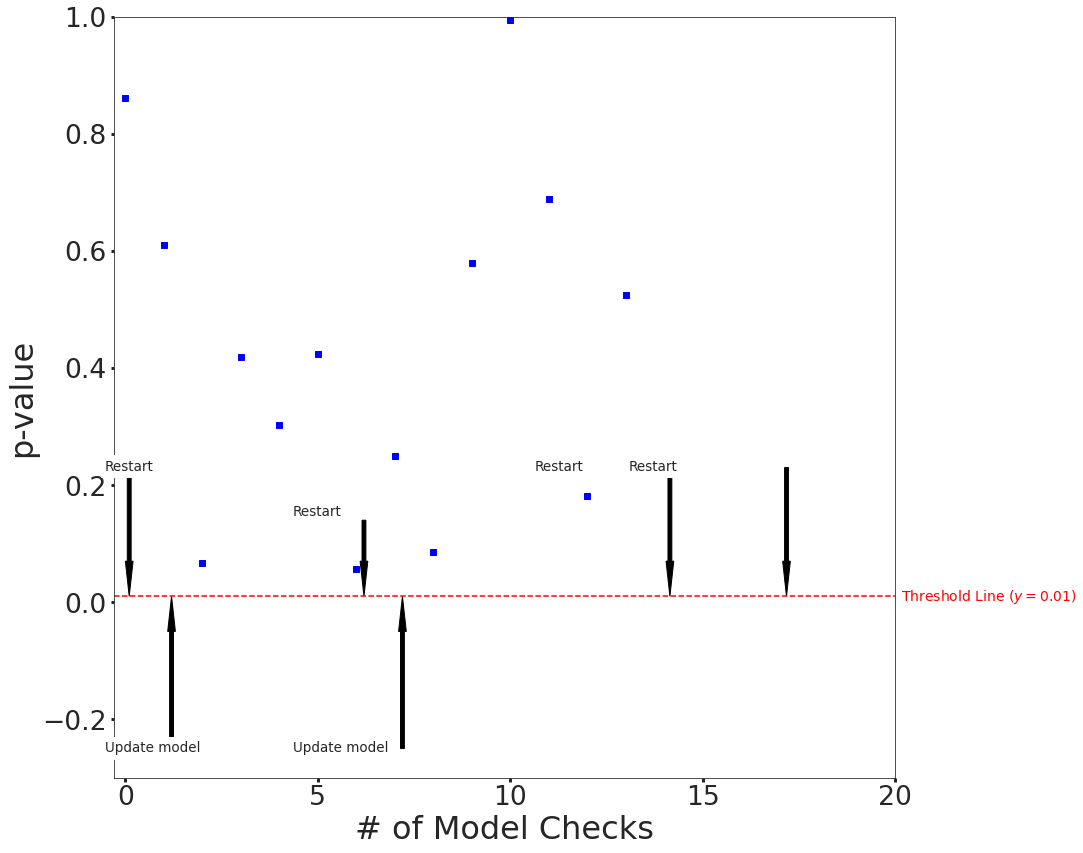

In [11]:
sns.set_style('ticks')
#plt.rcParams["pdf.use14corefonts"] = True
data_fit_vec_plot = 0.5* data_fit_vec.detach()[1:]
entropy_vec_plot = entropy_vec.detach()[1:]
p21_vec_plot = p21_vec.detach()[1:]
f, ax = plt.subplots(1, 1, figsize=(14, 14))
#ax.plot(np.array(range(2,iter+2)), torch.log(entropy_vec_plot), '+-')
#print(p21_vec_plot)
ax.plot(p21_vec_plot,'s',color = 'blue', markersize=6)
ax.axhline(.01,linestyle = '--',color = 'red', markersize=12, alpha = 1.0)
ax.set_xlim(-0.3, p21_vec_plot.shape[0])
ax.set_ylim(-0.3, 1.)
#ax.set_yscale('log')
plt.xticks(np.arange(0, iter+7, step=5.))
ax.tick_params(labelsize='small', width=3)
ax.set_xlabel('# of Model Checks')
ax.set_ylabel('p-value')
ax.annotate('Update model', xy=(0.55, 0.2), xytext=(0.05, 0.03), xycoords='axes fraction', 
            fontsize=9*1.5, ha='center', va='bottom',
            bbox=dict(boxstyle='square', fc='white'))
ax.arrow(1.2,        #x start point
             -0.25,                      #y start point
             0,       #change in x 
             0.2,                      #change in y
             head_width=0.2,         #arrow head width
             head_length=0.06,        #arrow head length
             width=0.1,              #arrow stem width
             fc='black',             #arrow fill color
             ec='black')             #arrow edge color

ax.annotate('Restart', xy=(0.55, 0.2), xytext=(0.02, 0.4), xycoords='axes fraction', 
            fontsize=9*1.5, ha='center', va='bottom',
            bbox=dict(boxstyle='square', fc='white'))
ax.arrow(0.1,        #x start point
             0.23,                      #y start point
             0,       #change in x 
             -0.16,                      #change in y
             head_width=0.2,         #arrow head width
             head_length=0.06,        #arrow head length
             width=0.1,              #arrow stem width
             fc='black',             #arrow fill color
             ec='black') 


############################
ax.annotate('Restart', xy=(0.55, 0.2), xytext=(0.26, 0.34), xycoords='axes fraction', 
            fontsize=9*1.5, ha='center', va='bottom',
            bbox=dict(boxstyle='square', fc='white'))
ax.arrow(6.2,        #x start point
             0.14,                      #y start point
             0,       #change in x 
             -0.07,                      #change in y
             head_width=0.2,         #arrow head width
             head_length=0.06,        #arrow head length
             width=0.1,              #arrow stem width
             fc='black',             #arrow fill color
             ec='black') 



ax.annotate('Update model', xy=(0.55, 0.2), xytext=(0.29, 0.03), xycoords='axes fraction', 
            fontsize=9*1.5, ha='center', va='bottom',
            bbox=dict(boxstyle='square', fc='white'))
ax.arrow(7.2,        #x start point
             -0.25,                      #y start point
             0,       #change in x 
             0.2,                      #change in y
             head_width=0.2,         #arrow head width
             head_length=0.06,        #arrow head length
             width=0.1,              #arrow stem width
             fc='black',             #arrow fill color
             ec='black')             #arrow edge color

############################
ax.annotate('Restart', xy=(0.55, 0.2), xytext=(0.57, 0.4), xycoords='axes fraction', 
            fontsize=9*1.5, ha='center', va='bottom',
            bbox=dict(boxstyle='square', fc='white'))
ax.arrow(14.15,        #x start point
             0.23,                      #y start point
             0,       #change in x 
             -0.16,                      #change in y
             head_width=0.2,         #arrow head width
             head_length=0.06,        #arrow head length
             width=0.1,              #arrow stem width
             fc='black',             #arrow fill color
             ec='black') 
################################


############################
ax.annotate('Restart', xy=(0.55, 0.2), xytext=(0.69, 0.4), xycoords='axes fraction', 
            fontsize=9*1.5, ha='center', va='bottom',
            bbox=dict(boxstyle='square', fc='white'))
ax.arrow(17.18,        #x start point
             0.23,                      #y start point
             0,       #change in x 
             -0.16,                      #change in y
             head_width=0.2,         #arrow head width
             head_length=0.06,        #arrow head length
             width=0.1,              #arrow stem width
             fc='black',             #arrow fill color
             ec='black') 
################################



# ax.annotate('Update model', xy=(0.55, 0.2), xytext=(0.32, 0.03), xycoords='axes fraction', 
#             fontsize=9*1.5, ha='center', va='bottom',
#             bbox=dict(boxstyle='square', fc='white'))
# ax.arrow(10.25,        #x start point
#              -0.25,                      #y start point
#              0,       #change in x 
#              0.2,                      #change in y
#              head_width=0.2,         #arrow head width
#              head_length=0.06,        #arrow head length
#              width=0.1,              #arrow stem width
#              fc='black',             #arrow fill color
#              ec='black')             #arrow edge color

# ############################

# ############################
# ax.annotate('Restart', xy=(0.55, 0.2), xytext=(0.33, 0.34), xycoords='axes fraction', 
#             fontsize=9*1.5, ha='center', va='bottom',
#             bbox=dict(boxstyle='square', fc='white'))
# ax.arrow(11.25,        #x start point
#              0.14,                      #y start point
#              0,       #change in x 
#              -0.07,                      #change in y
#              head_width=0.2,         #arrow head width
#              head_length=0.06,        #arrow head length
#              width=0.1,              #arrow stem width
#              fc='black',             #arrow fill color
#              ec='black') 
# #################################################

# ################################


# ax.annotate('Update model', xy=(0.55, 0.2), xytext=(0.38, 0.1), xycoords='axes fraction', 
#             fontsize=9*1.5, ha='center', va='bottom',
#             bbox=dict(boxstyle='square', fc='white'))
# ax.arrow(12.25,        #x start point
#              -0.15,                      #y start point
#              0,       #change in x 
#              0.1,                      #change in y
#              head_width=0.2,         #arrow head width
#              head_length=0.06,        #arrow head length
#              width=0.1,              #arrow stem width
#              fc='black',             #arrow fill color
#              ec='black')             #arrow edge color





################################




# ax.annotate('Restart', xy=(0.55, 0.2), xytext=(0.38, 0.4), xycoords='axes fraction', 
#             fontsize=9*1.5, ha='center', va='bottom',
#             bbox=dict(boxstyle='square', fc='white'))
# ax.arrow(13.25,        #x start point
#              0.23,                      #y start point
#              0,       #change in x 
#              -0.16,                      #change in y
#              head_width=0.2,         #arrow head width
#              head_length=0.06,        #arrow head length
#              width=0.1,              #arrow stem width
#              fc='black',             #arrow fill color
#              ec='black') 
# ################################


# ax.annotate('Update model', xy=(0.55, 0.2), xytext=(0.55, 0.03), xycoords='axes fraction', 
#             fontsize=9*1.5, ha='center', va='bottom',
#             bbox=dict(boxstyle='square', fc='white'))
# ax.arrow(18.25,        #x start point
#              -0.25,                      #y start point
#              0,       #change in x 
#              0.2,                      #change in y
#              head_width=0.2,         #arrow head width
#              head_length=0.06,        #arrow head length
#              width=0.1,              #arrow stem width
#              fc='black',             #arrow fill color
#              ec='black')  
# ################################




# ax.annotate('Restart', xy=(0.55, 0.2), xytext=(0.49, 0.4), xycoords='axes fraction', 
#             fontsize=9*1.5, ha='center', va='bottom',
#             bbox=dict(boxstyle='square', fc='white'))
# ax.arrow(17.25,        #x start point
#              0.23,                      #y start point
#              0,       #change in x 
#              -0.16,                      #change in y
#              head_width=0.2,         #arrow head width
#              head_length=0.06,        #arrow head length
#              width=0.1,              #arrow stem width
#              fc='black',             #arrow fill color
#              ec='black') 
# ################################

# ################################




# ax.annotate('Restart', xy=(0.55, 0.2), xytext=(0.55, 0.43), xycoords='axes fraction', 
#             fontsize=9*1.5, ha='center', va='bottom',
#             bbox=dict(boxstyle='square', fc='white'))
# ax.arrow(19.25,        #x start point
#              0.26,                      #y start point
#              0,       #change in x 
#              -0.19,                      #change in y
#              head_width=0.2,         #arrow head width
#              head_length=0.06,        #arrow head length
#              width=0.1,              #arrow stem width
#              fc='black',             #arrow fill color
#              ec='black') 
# ################################

# ax.annotate('Restart', xy=(0.55, 0.2), xytext=(0.94, 0.43), xycoords='axes fraction', 
#             fontsize=9*1.5, ha='center', va='bottom',
#             bbox=dict(boxstyle='square', fc='white'))
# ax.arrow(33.25,        #x start point
#              0.26,                      #y start point
#              0,       #change in x 
#              -0.19,                      #change in y
#              head_width=0.2,         #arrow head width
#              head_length=0.06,        #arrow head length
#              width=0.1,              #arrow stem width
#              fc='black',             #arrow fill color
#              ec='black') 
# ################################


# ################################

ax.annotate('Threshold Line ($y = 0.01$)', xy=(1.0,0.01), xytext=(6,0), color='red', 
                xycoords = ax.get_yaxis_transform(), textcoords="offset points",
                size=14, va="center")


#ax.legend(['p-value'], loc = 'upper left', fontsize = 30)
plt.savefig('figures_Carlo/qvalue_base.pdf',dpi=300, bbox_inches='tight')
plt.show()

# Putting the data back to CPU for plotting and analysis

In [12]:
if use_cuda:
    vec_x = vec_x.cpu()
    g_theta1 = g_theta1.cpu()
    g_theta2 = g_theta2.cpu()
    agg_data = agg_data.cpu()
    f_target = f_target.cpu()
    x_train, y_train = x_train.cpu(), y_train.cpu()
    loss = loss.cpu()
    pf1 = pf1.cpu()
    Qf1 = Qf1.cpu()
    Qf12 = Qf12.cpu()
    Q21 = Q21.cpu()
    data_fit_vec = data_fit_vec.cpu()
    entropy_vec = entropy_vec.cpu()

# Plotting expected value and data fit term

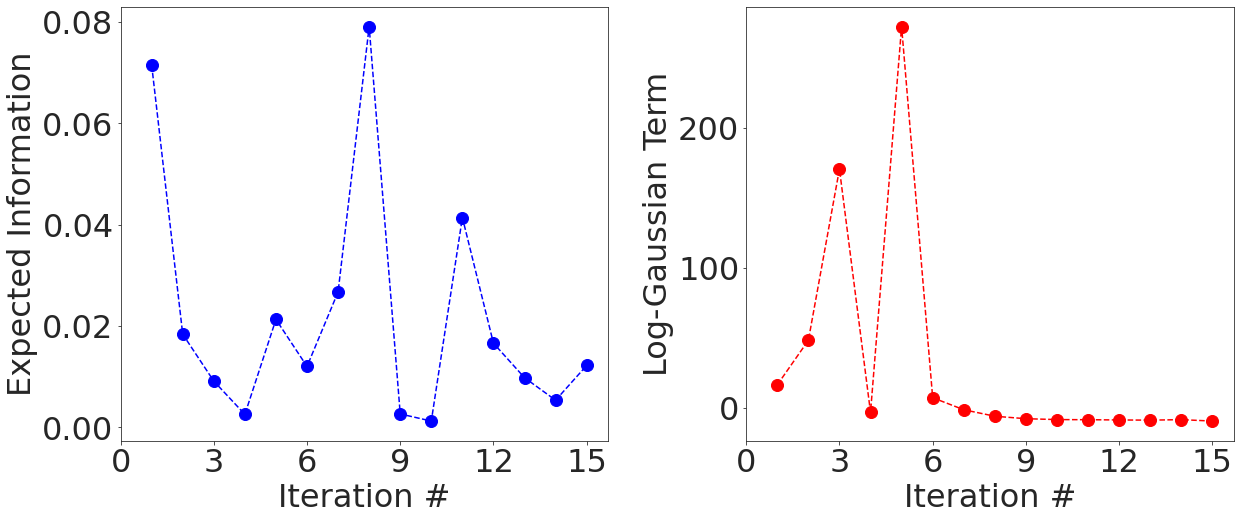

In [13]:
sns.set_style('ticks')
data_fit_vec_plot = 0.5* data_fit_vec.detach()[1:]
entropy_vec_plot = entropy_vec.detach()[1:]
f, (ax1,ax2) = plt.subplots(1, 2, figsize=(18, 8), tight_layout=True)

ax1.plot(np.array(range(1,iter+2)), (entropy_vec_plot), '--o', color = 'blue', markersize=12)
#ax1.set_yscale('log')
# ax.plot(np.array(data_fit_vec_plot), (entropy_vec_plot), 'o')
#ax1.set_yscale('log')

ax2.plot(np.array(range(1,iter+2)), data_fit_vec_plot, '--o', color = 'red', markersize=12)
#ax2.set_ylim(-10, 600)
ax1.set_xlabel('Iteration #', size=32)
ax2.set_xlabel('Iteration #', size=32)
ax1.set_ylabel('Expected Information', size = 32)
ax2.set_ylabel('Log-Gaussian Term', size = 32)
ax1.set_xticks(np.arange(0, iter+3, step=3.))
ax2.set_xticks(np.arange(0, iter+3, step=3.))
plt.savefig('figures_Carlo/exp_info/expectedinfo_vs_datafit_2_base.pdf',dpi=300, bbox_inches='tight')
plt.show()

# Saving all data needed for plots

In [14]:
np.savetxt('data_plots/vec_x_success_base.txt',vec_x.detach().numpy())
np.savetxt('data_plots/g_theta2_success_base.txt', g_theta2.detach().numpy())
np.savetxt('data_plots/g_theta1_success_base.txt', g_theta1.detach().numpy())
np.savetxt('data_plots/x_train_ini_success_base.txt', x_train.detach().numpy())
np.savetxt('data_plots/y_train_ini_success_base.txt', y_train.detach().numpy())
np.savetxt('data_plots/entropy_vec_success_base.txt', entropy_vec_plot.detach().numpy())
np.savetxt('data_plots/datafit_success_base.txt', data_fit_vec_plot.detach().numpy())
np.savetxt('data_plots/p21_vec_success_base.txt',p21_vec_plot.detach().numpy())
np.savetxt('data_plots/loss_success_base.txt',loss.detach().numpy())
np.savetxt('data_plots/pf1_success_base.txt',pf1.detach().numpy())
np.savetxt('data_plots/Qf1_success_base.txt',Qf1.evaluate().detach().numpy())
np.savetxt('data_plots/Qf12_success_base.txt', Qf12.evaluate().detach().numpy())
np.savetxt( 'data_plots/Q21_success_base.txt', Q21.evaluate().detach().numpy())
#np.savetxt('data_plots/iter_success.txt', iter+1)

In [15]:
v2 = g_theta2_vec.reshape(math.ceil(g_theta2_vec.shape[0]/2),2)
torch.save(v2, 'data_plots/v2_success_base.txt')

# Plots for vizualization

/tmp/ipykernel_697686/2505842117.py:7: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "gd" (-> color='g'). The keyword argument will take precedence.
  ax.plot(0.8731, 0.5664,'gd', color = 'green',markersize=15)


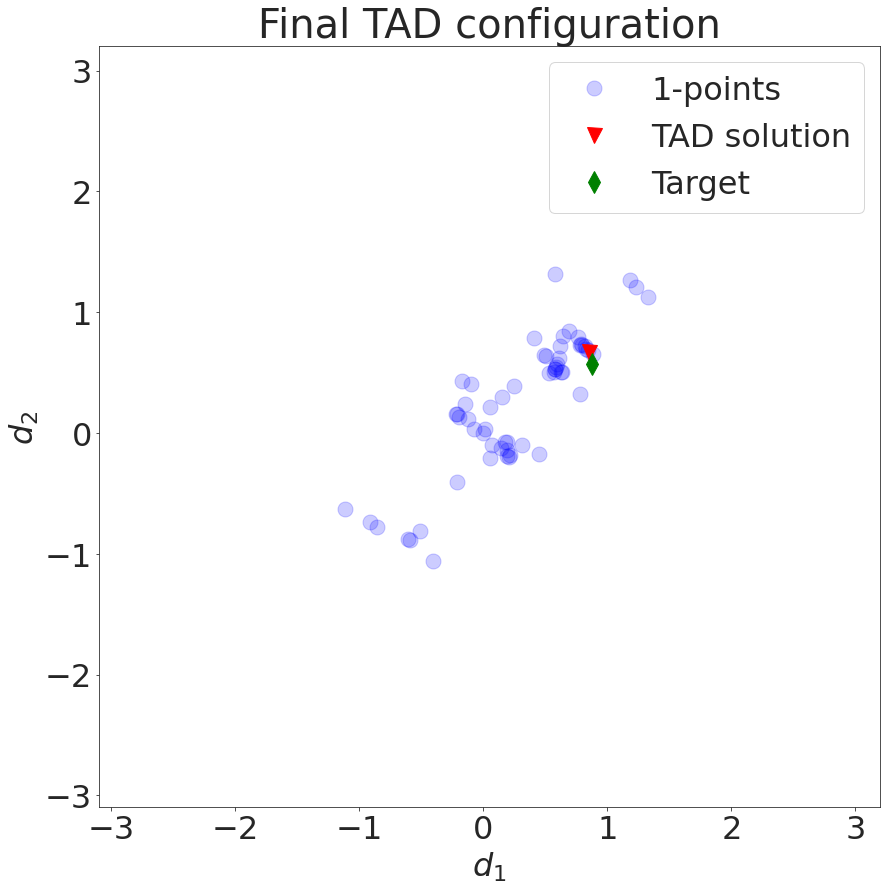

In [16]:
fig, ax = plt.subplots(figsize = (14,14))
ax.set_xlim(-3.1, 3.2)
ax.set_ylim(-3.1, 3.2)
#ax.scatter(g_theta1[:, 0].detach(),g_theta1[:, 1].detach(), c="b", alpha=0.8)
ax.plot(g_theta1[:, 0].detach(),g_theta1[:, 1].detach() , 'o', color = 'blue',markersize=15, alpha = 0.2)
ax.plot(vec_x[-1,0], vec_x[-1,1],'v', color = 'red',markersize=15)
ax.plot(0.8731, 0.5664,'gd', color = 'green',markersize=15)
ax.set_title('Final TAD configuration', fontsize = 40)
ax.set_xlabel('$d_1$')
ax.set_ylabel('$d_2$')
ax.legend(['1-points', 'TAD solution', 'Target'])
plt.savefig('figures_Carlo/strategies/tad_sol_all_2_base.pdf')
plt.show()

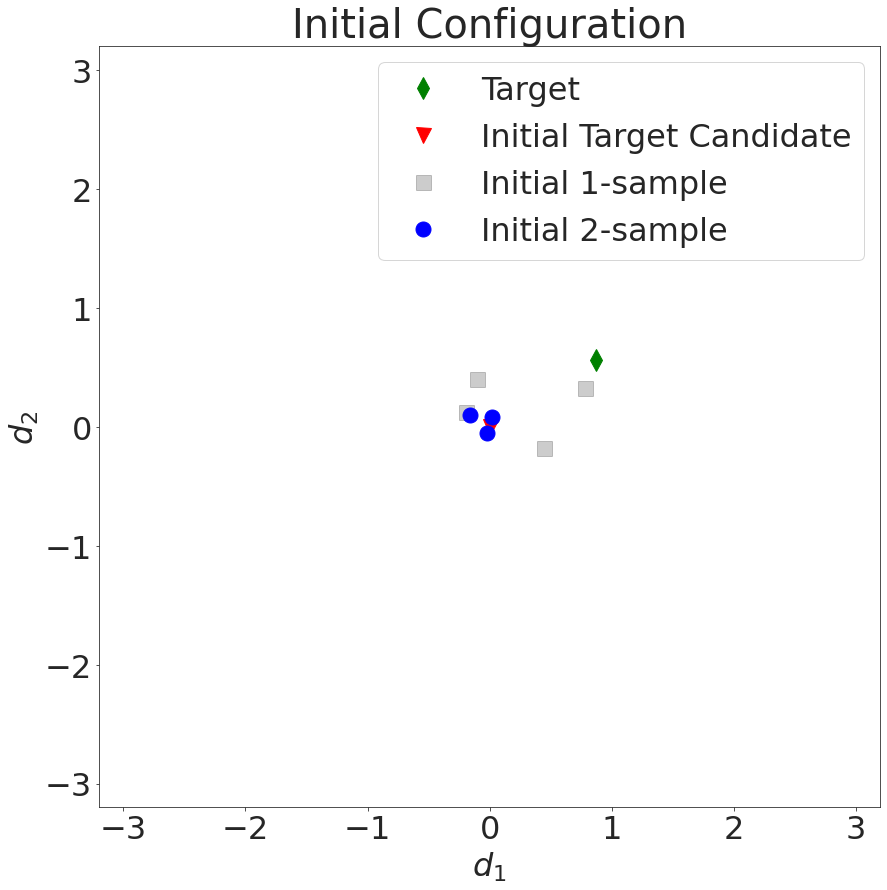

In [17]:
vec_x = vec_x.detach()
#v2 = g_theta2_vec.reshape(math.ceil(g_theta2_vec.shape[0]/2), 2)
ii = 0
low = -3.2
high = 3.2
v2 = v2.cpu()
########################
f, ax = plt.subplots(1, 1, figsize=(14, 14))
ax.plot(0.8731, 0.5664,'d', color = 'green',markersize=15)
ax.plot(vec_x[ii,0], vec_x[ii,1],'v', color = 'red',markersize=15)
ax.plot(x_train.detach()[:,0], x_train.detach()[:,1], 's', color = 'black', markersize=15, alpha = 0.2)
ax.plot(v2.detach()[ii:ii+loc_size+1,0], v2.detach()[ii:ii+loc_size+1,1], 'o', color = 'blue', markersize=15)
ax.set_xlabel('$d_1$')
ax.set_ylabel('$d_2$')
ax.set_title('Initial Configuration', fontsize = 40)
ax.legend(['Target', 'Initial Target Candidate', 'Initial 1-sample','Initial 2-sample'])

ax.set_xlim(low, high)
ax.set_ylim(low, high)
plt.savefig('figures_Carlo/evol_solTAD/evol_sol_ini_2_base.pdf')

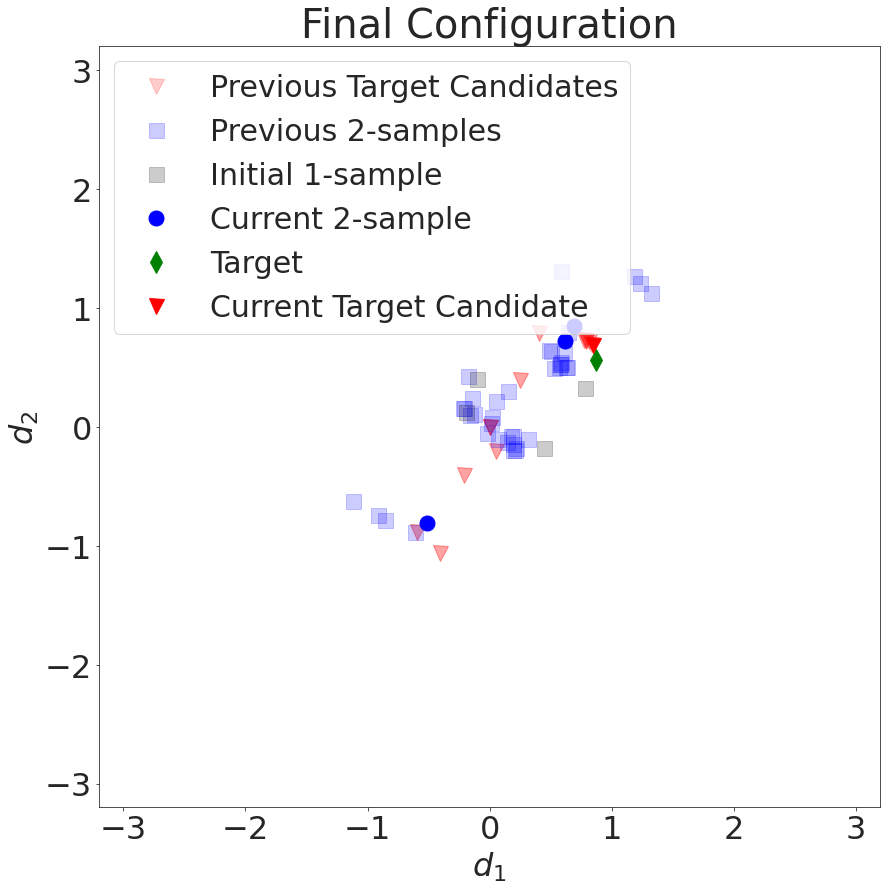

In [18]:
vec_x = vec_x.detach()
v2 = g_theta2_vec.reshape(math.ceil(g_theta2_vec.shape[0]/2), 2).cpu()

low = -3.2
high = 3.2
#for iter_plt in range(1,iter):
iter_plt = 13
ii = 3 + (iter_plt - 1) * (loc_size + 1)
#######################

 
###########

f, ax = plt.subplots(1, 1, figsize=(14,14))

#ax.plot(x_train.detach()[:,0], x_train.detach()[:,1], 'bv', markersize=8)
for i in range(1, iter_plt):
    ax.plot(vec_x[i-1:i,0], vec_x[i-1:i,1],'v', color = 'red', markersize=15, alpha=0.2, label = '_nolegend_')
    
ax.plot(vec_x[0:iter_plt,0], vec_x[0:iter_plt,1],'v', color = 'red', markersize=15, linewidth=15, alpha= 0.2)
#ax.plot(g_theta1.detach()[:,0], g_theta.detach()[:,1], 'bv', markersize=8)
ax.plot(v2.detach()[0:ii,0], v2.detach()[0:ii,1], 's', color = 'blue', markersize=15,alpha=0.2)
ax.plot(x_train.detach()[:,0], x_train.detach()[:,1], 's', color = 'black', markersize=15, alpha = 0.2)
ax.plot(v2.detach()[ii:ii+loc_size+1,0], v2.detach()[ii:ii+loc_size+1,1], 'o',color = 'blue' , markersize=15)
ax.plot(0.8731, 0.5664,'gd',markersize=15)
ax.plot(vec_x[iter_plt,0], vec_x[iter_plt,1],'v', color = 'red',markersize=15)
ax.set_xlabel('$d_1$')
ax.set_ylabel('$d_2$')
#ax.set_title('Iteration '+str(iter_plt), fontsize = 40)
ax.set_title('Final Configuration')
ax.legend([ 'Previous Target Candidates', 'Previous 2-samples', 'Initial 1-sample','Current 2-sample', 'Target', 'Current Target Candidate'], fontsize = 30)

ax.set_xlim(low, high)
ax.set_ylim(low, high)
plt.savefig('figures_Carlo/evol_solTAD/evol_sol_base'+str(iter_plt)+'_final.pdf')

### The below function shouldn't take long, so do it on CPU as well

# Grid Sampling

In [19]:
def conduct_design_pll(x0,f_target, g_theta1, agg_data, model, likelihood, training_design_iter, training_param_iter, lr_new,noise_value):

    #g_theta2 = nn.Parameter(Tensor(loc_sample))
    f_target = f_target.cpu()

    x_d= nn.Parameter(Tensor(x0))
    
    optimizer = torch.optim.Adam([{'params': x_d, 'lr': 0.001}])

    #scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer)
    
    for ii in range( training_param_iter ):
#         x_d = torch.cat([x_d_0, x_d_1]).reshape(1,2)
#         g_theta2 = torch.cat([g_theta20, g_theta21],1)
        optimizer.zero_grad()
        #print(g_theta)
        loss2,lower_bound, upper_bound = likelihood.get_pll(f_target,x_d, g_theta1, agg_data, model, likelihood, noise_value)
        loss2 = -1. * loss2
        
        loss2.backward()
        
        optimizer.step()
        
    loss2,lower_bound, upper_bound = likelihood.get_pll(f_target,x_d, g_theta1, agg_data, model, likelihood ,noise_value)
    #loss2 = -1. * loss2
    print('Loss design: %.3f' % ( loss2))
   # print(optimizer.state_dict())
    print(x_d)
    return x_d, lower_bound, upper_bound
    

In [20]:
# Ensure everything is on CPU
use_cuda = False
####
f_target = f_target.cpu()
tol_vector = tol_vector.cpu()

x_plot = np.linspace(vf.low, vf.high, 15)
y_plot = np.linspace(vf.low, vf.high, 15)
xv_plot, yv_plot = np.meshgrid(x_plot, y_plot)
n = x_plot.shape[0]
x_concat = torch.zeros(n * n, 2)
i = 0
k = 0
while i < n*n:
    x_concat[i:i+n,0] = Tensor(xv_plot[:,k])
    x_concat[i:i+n,1] = Tensor(y_plot)
    k = k+1
    i = i+n

g_theta_grid = x_concat
agg_data1_grid = vfield_(g_theta_grid)
agg_data1_grid = agg_data1_grid.flatten()


x0 = Tensor(np.array([-2.,2.])) 
x0 = x0.reshape(1,2)
x00 = x0 
vec_x_grid = Tensor(np.array([0.0,0.0])) 
vec_x_grid = vec_x_grid.reshape(1,2)

lr_new = 1.

SUCCESS = False 
FAILURE = False 
 
tol = 0.009 
print('START HYPERPARAMETERS optimization')
model_grid, likelihood_grid = hyper_opti(g_theta_grid,agg_data1_grid,iter_hp,num_base_kernels,noise_value)

print('END HYPERPARAMETERS optimization')
model_grid.eval()
likelihood_grid.eval()
x0_new_grid,lower_bound, upper_bound = conduct_design_pll(x0,f_target, g_theta_grid, agg_data1_grid, model_grid, likelihood_grid, iter_design, iter_param, lr_new,noise_value)
print(lower_bound)
print(upper_bound)
print(f_target-tol_vector)
print(f_target+tol_vector)
#loc_sample = np.random.random_sample((loc_size_rdn,2))


SUCCESS = stopping_criteria(tol_vector, f_target, lower_bound, upper_bound)


print(x0_new_grid)
print(SUCCESS)

START HYPERPARAMETERS optimization
Using CPU
loss is -3.033
END HYPERPARAMETERS optimization
Loss design: -1.955
Parameter containing:
tensor([[-2.0956,  2.0958]], requires_grad=True)
tensor([[0.0373],
        [0.0735]], grad_fn=<CopySlices>)
tensor([[0.7612],
        [0.8186]], grad_fn=<CopySlices>)
tensor([[0.3280],
        [0.3402]])
tensor([[0.3480],
        [0.3602]])
Parameter containing:
tensor([[-2.0956,  2.0958]], requires_grad=True)
False


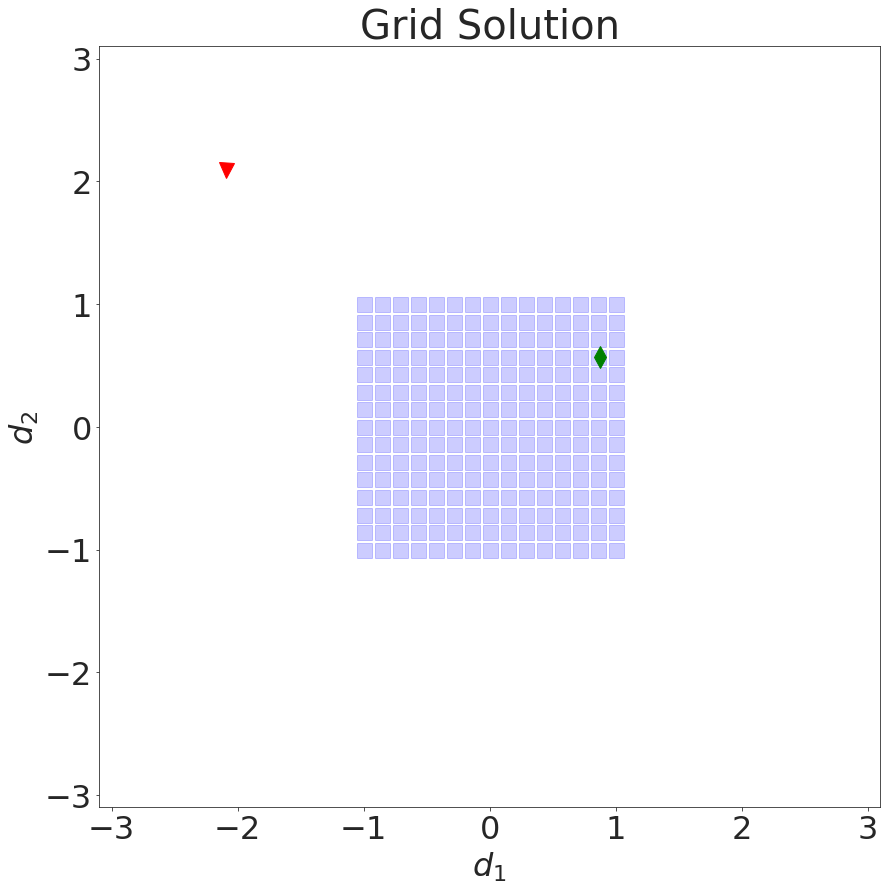

In [21]:
x0_grid = x0_new.detach()
fig, ax = plt.subplots(figsize = (14,14))
ax.plot(x_concat[:,0],x_concat[:,1], 's', color = 'blue', markersize=15, alpha = 0.2)
ax.plot(x0_new_grid.detach()[0,0], x0_new_grid.detach()[0,1],'v',color = 'red',markersize=15)
ax.plot(0.8731, 0.5664,'d', color = 'green',markersize=15)

ax.set_xlim(-3.1, 3.1)
ax.set_ylim(-3.1, 3.1)
ax.set_xlabel('$d_1$')
ax.set_ylabel('$d_2$')
ax.set_title('Grid Solution', fontsize = 40)

plt.savefig('figures_Carlo/strategies/grid_sol_2_base.pdf')

# Random sampling

In [22]:
# iter_hp = 30
# iter_design = 40 
# iter_param = 50
# num_base_kernels = 3

# f_target = Tensor(vf.tgt_vec) 
# f_target = f_target.reshape(f_target.shape[0],1) 
# tol_vector = 0.005 * torch.ones(f_target.shape)


loc_size_rdn = math.ceil(g_theta1.shape[0]) #(iter)*(loc_size+1) + sample_size

loc_sample = high_minus_low  * np.random.random_sample((loc_size_rdn,2)) + vf.low #np.random.random_sample((loc_size_rdn,2))
g_theta_ = (Tensor(loc_sample).clone())
agg_data1 = vfield_(g_theta_)
agg_data1 = agg_data1.flatten()


x0 = Tensor(np.array([-2.0,2.0])) 
x0 = x0.reshape(1,2)
x00 = x0 
vec_x_rdn = Tensor(np.array([0.,0.])) 
vec_x_rdn = vec_x_rdn.reshape(1,2)

lr_new = 1.


SUCCESS = False 
FAILURE = False 
 
tol = 0.009 
print('START HYPERPARAMETERS optimization')

model_rdn, likelihood_rdn = hyper_opti(g_theta_,agg_data1,iter_hp,num_base_kernels,noise_value)




print('END HYPERPARAMETERS optimization')
model_rdn.eval()
likelihood_rdn.eval()
x0_new_rdn,lower_bound, upper_bound = conduct_design_pll(x0,f_target, g_theta_, agg_data1, model_rdn, likelihood_rdn, iter_design, iter_param, lr_new, noise_value)
print(lower_bound)
print(upper_bound)
print(f_target-tol_vector)
print(f_target+tol_vector)
loc_sample = np.random.random_sample((loc_size_rdn,2))


SUCCESS = stopping_criteria(tol_vector, f_target, lower_bound, upper_bound)


print(x0_new_rdn)
print(SUCCESS)
sol_rdn = x0_new_rdn

START HYPERPARAMETERS optimization
Using CPU
loss is -2.728
END HYPERPARAMETERS optimization
Loss design: -1.819
Parameter containing:
tensor([[-2.1061,  1.8959]], requires_grad=True)
tensor([[-0.2310],
        [ 0.0552]], grad_fn=<CopySlices>)
tensor([[0.3102],
        [0.5959]], grad_fn=<CopySlices>)
tensor([[0.3280],
        [0.3402]])
tensor([[0.3480],
        [0.3602]])
Parameter containing:
tensor([[-2.1061,  1.8959]], requires_grad=True)
False


In [23]:
np.savetxt('data_plots/sol_rdn_success_base.txt', sol_rdn.detach().numpy())
np.savetxt('data_plots/sol_grid_success_base.txt', x0_new_grid.detach().numpy())
np.savetxt('data_plots/g_theta_rdn_success_base.txt', g_theta_.detach().numpy())
#np.savetxt('data_plots/g_theta_grid_success.txt', x_concat.detach().numpy)

In [24]:
print(g_theta1.shape)

torch.Size([60, 2])


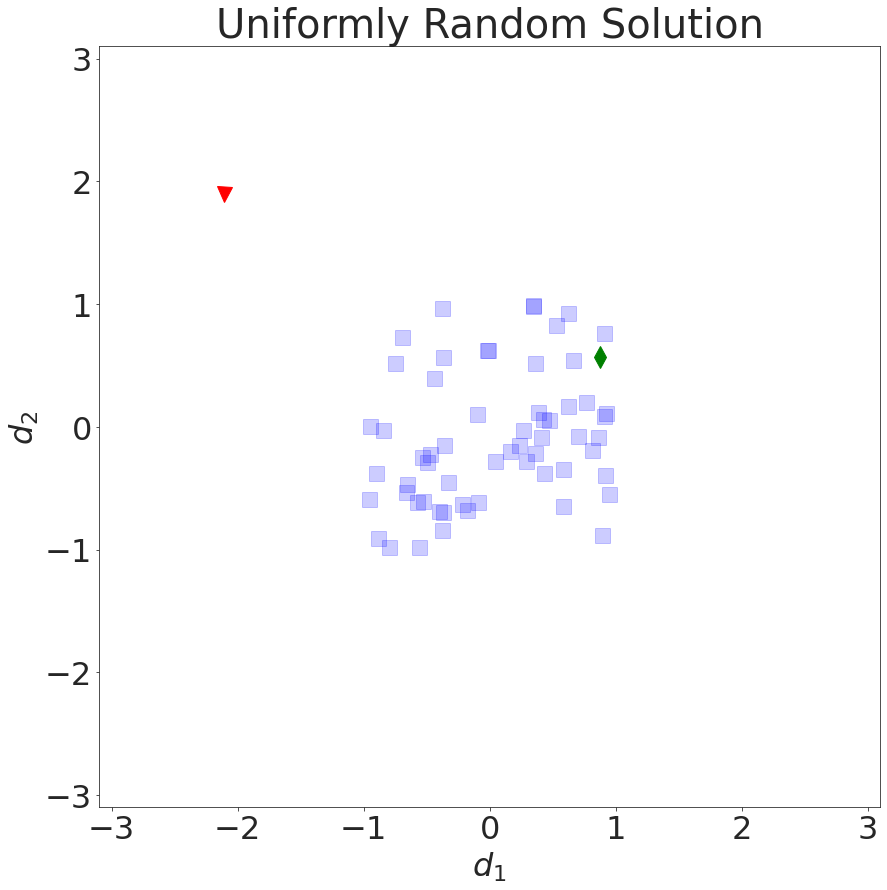

In [25]:
fig, ax = plt.subplots(figsize = (14,14))

ax.plot(g_theta_[:,0].detach(),g_theta_[:,1].detach(), 's', color = 'blue',markersize=15, alpha = 0.2)
ax.plot(sol_rdn.detach()[0,0], sol_rdn.detach()[0,1],'v', color = 'red',markersize=15)
ax.plot(0.8731, 0.5664,'d', color = 'green',markersize=15)

ax.set_xlim(-3.1, 3.1)
ax.set_ylim(-3.1, 3.1)
ax.set_xlabel('$d_1$', fontsize = 32)
ax.set_ylabel('$d_2$', fontsize = 32)
ax.set_title('Uniformly Random Solution', fontsize = 40)

plt.savefig('figures_Carlo/strategies/rdn_sol_2_base.pdf')

# Vizualizing Means and Variances

In [26]:
import matplotlib.ticker
class OOMFormatter(matplotlib.ticker.ScalarFormatter):
    def __init__(self, order=0, fformat="%1.1f", offset=True, mathText=True):
        self.oom = order
        self.fformat = fformat
        matplotlib.ticker.ScalarFormatter.__init__(self,useOffset=offset,useMathText=mathText)
    def _set_order_of_magnitude(self):
        self.orderOfMagnitude = self.oom
    def _set_format(self, vmin=None, vmax=None):
        self.format = self.fformat
        if self._useMathText:
             self.format = r'$\mathdefault{%s}$' % self.format

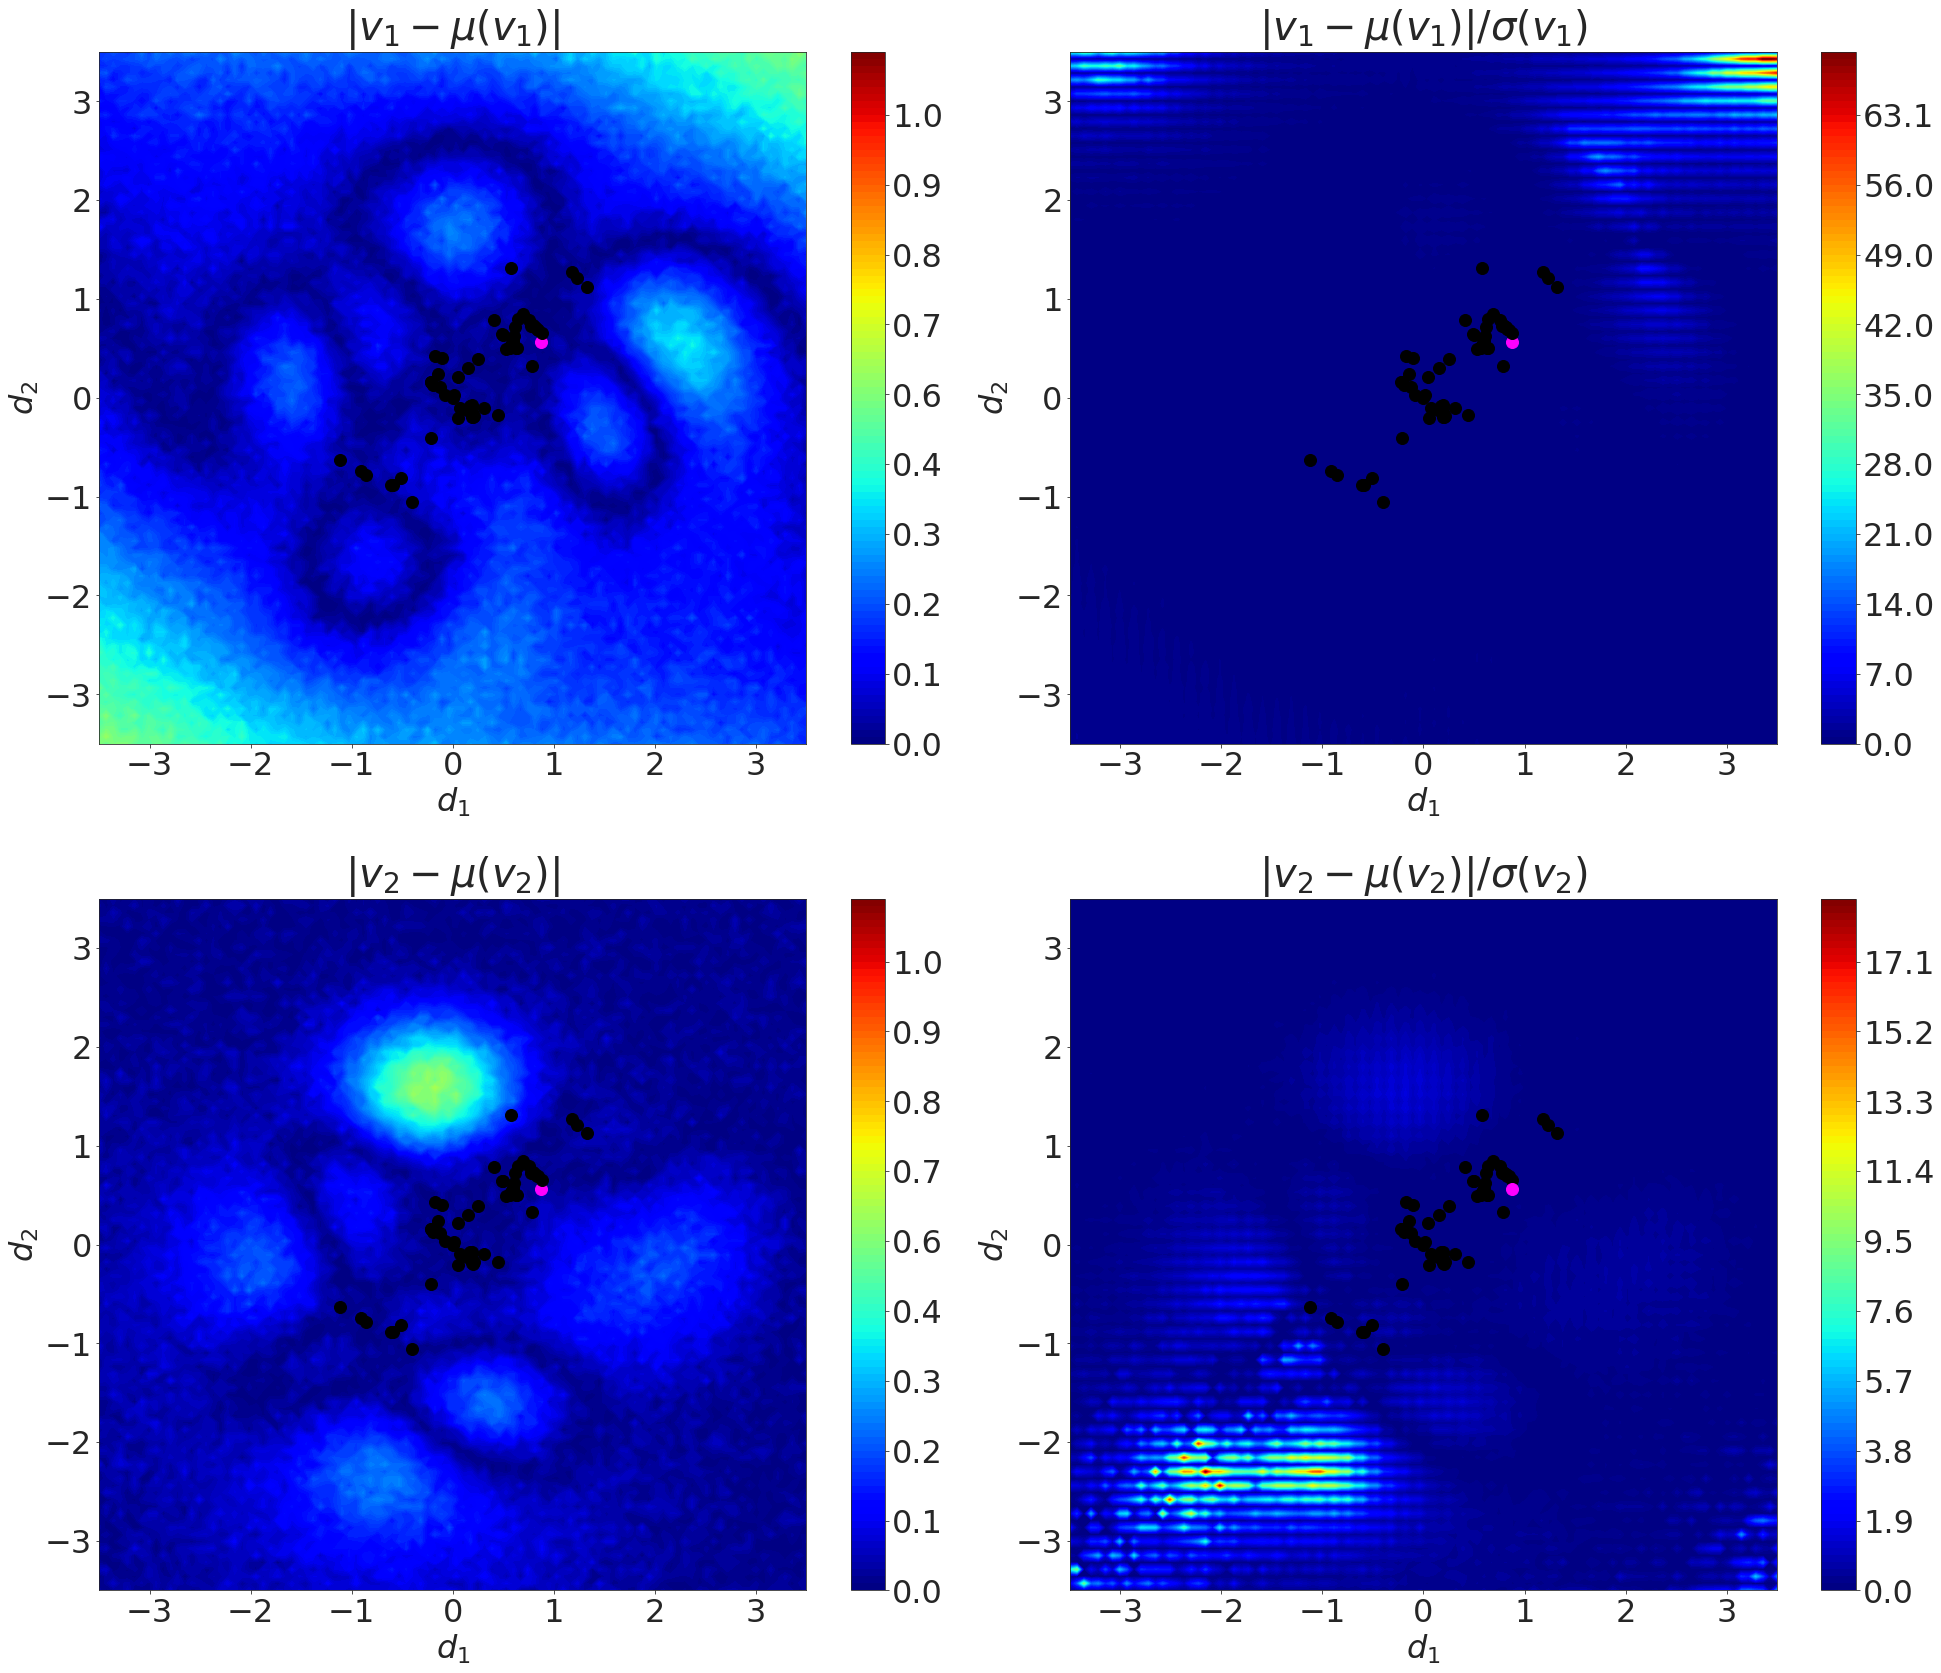

In [27]:
f_target = vf.tgt_vec
f_target = f_target.reshape(f_target.shape[0],1)
vf.tgt_loc = vf.tgt_loc.reshape(2,1)
#x0 = Tensor(np.array([0.1937, 0.1257]))
#x0 = Tensor(np.array([0.1885, 0.1038]))
x_plot = np.linspace(-3.5, 3.5, 100)
y_plot = np.linspace(-3.5, 3.5, 100)
xv_plot, yv_plot = np.meshgrid(x_plot, y_plot)
n = x_plot.shape[0]
x_concat_ = torch.zeros(n * n, 2)

# n_sample = x_concat_.shape[0]
num_tasks = 2
i = 0
k = 0
while i < n*n:
    x_concat_[i:i+n,0] = Tensor(xv_plot[:,k])
    x_concat_[i:i+n,1] = Tensor(y_plot)
    k = k+1
    i = i+n
    

tgt_plot = vfield_(x_concat_)



v_1 = tgt_plot[:,0].reshape(n,n)
v_2 = tgt_plot[:,1].reshape(n,n)

model.eval()

likelihood.eval()

#noise = torch.eye(2 * g_theta1.detach().shape[0]) * noise_value
#print(x_concat_)
with torch.no_grad(), gpytorch.settings.fast_pred_var(True):
    model = model.cpu()
    pred = GPprediction(model)
    agg_data = agg_data.cpu()
    pr_mean, cov = pred.GPpred(g_theta1.detach(), agg_data, x_concat_, noise_value)
    #pr = (model(g_theta1.detach())) # likelihood(model(x_concat_), noise = torch.ones(x_concat_.shape) * noise_value)#
    pr_mean = pr_mean.reshape(x_concat_.shape[0], num_tasks)
    mean_v_1 = pr_mean[:,0].reshape(n,n)
    mean_v_2 = pr_mean[:,1].reshape(n,n)
    pred_var = cov.diag().reshape(num_tasks, x_concat_.shape[0]).T
    
    var_v_1 = pred_var[:,0].reshape(n,n)
    var_v_2 = pred_var[:,1].reshape(n,n)
#     AA = pr.covariance_matrix.mean(axis=0).reshape(num_tasks, x_concat_.shape[0]).T #.diag() #.reshape(num_tasks, num_tasks * g_theta1.shape[0]).T

# #     print(pr.covariance_matrix.mean(axis=0))
# #     print(AA)
# #     print(pr.variance)
# #     print((pr.covariance_matrix))
# #     K = model.covar_module
#     print((cov.diag()))
#     print(pr_mean)


fig, (ax1, ax2) = plt.subplots(2, 2, figsize = (28, 24), tight_layout=True)
diff_mean_v1= torch.abs(v_1 - mean_v_1.detach())#/torch.abs(v_1)
cs10 = ax1[0].contourf(xv_plot, yv_plot,diff_mean_v1 ,np.linspace(0, 1.1, 100), cmap = 'jet')
ax1[0].plot(vf.tgt_loc[0],vf.tgt_loc[1], 'o', color = 'magenta', markersize=12)
ax1[0].plot(g_theta1[:, 0].detach(),g_theta1[:, 1].detach() , 'o', color = 'black',markersize=12, alpha = 1.0)
ax1[0].set_title('$|v_1 - \mu(v_1)|$', fontsize = 40)
cbar10 = fig.colorbar(cs10, ax = ax1[0],format=OOMFormatter(0, mathText=False));

ax1[0].set_xlabel('$d_1$')
ax1[0].set_ylabel('$d_2$')
diff_mean_v1 = torch.abs(v_1 - mean_v_1.detach())/torch.sqrt(var_v_1)
#print(var_v_1)
cs11 = ax1[1].contourf(xv_plot, yv_plot,diff_mean_v1 ,np.linspace(diff_mean_v1.min(), diff_mean_v1.max(), 100), cmap = 'jet')
ax1[1].plot(vf.tgt_loc[0],vf.tgt_loc[1], 'o', color = 'magenta', markersize=12)
ax1[1].plot(g_theta1[:, 0].detach(),g_theta1[:, 1].detach() , 'o', color = 'black',markersize=12, alpha = 1.0)
ax1[1].set_title('$|v_1 - \mu(v_1)|/\sigma(v_1)$', fontsize = 40)
# ax1[0].set_aspect('equal')
# ax1[1].set_aspect('equal')
cbar11 = fig.colorbar(cs11, ax = ax1[1],format=OOMFormatter(0, mathText=False));
ax1[1].set_xlabel('$d_1$')
ax1[1].set_ylabel('$d_2$')


diff_mean_v2= torch.abs(v_2 - mean_v_2.detach())
cs20 = ax2[0].contourf(xv_plot, yv_plot, diff_mean_v2,np.linspace(0, 1.1, 100), cmap = 'jet')
ax2[0].plot(vf.tgt_loc[0],vf.tgt_loc[1], 'o', color = 'magenta', markersize=12)
ax2[0].plot(g_theta1[:, 0].detach(),g_theta1[:, 1].detach() , 'o', color = 'black',markersize=12, alpha = 1.0)
ax2[0].set_title('$|v_2 - \mu(v_2)|$', fontsize = 40)
cbar20 = fig.colorbar(cs20, ax = ax2[0],format=OOMFormatter(0, mathText=False));
ax2[0].set_xlabel('$d_1$')
ax2[0].set_ylabel('$d_2$')


diff_mean_v2= torch.abs(v_2 - mean_v_2.detach())/torch.sqrt(var_v_2)
cs21 = ax2[1].contourf(xv_plot, yv_plot, diff_mean_v2,np.linspace(diff_mean_v2.min(), diff_mean_v2.max(), 100), cmap = 'jet')
ax2[1].plot(g_theta1[:, 0].detach(),g_theta1[:, 1].detach() , 'o', color = 'black',markersize=12, alpha = 1.0)
ax2[1].plot(vf.tgt_loc[0],vf.tgt_loc[1], 'o', color = 'magenta', markersize=12)
ax2[1].set_title('$|v_2 - \mu(v_2)|/\sigma(v_2)$', fontsize = 40)
cbar21 = fig.colorbar(cs21, ax = ax2[1],format=OOMFormatter(0, mathText=False));
ax2[1].set_xlabel('$d_1$')
ax2[1].set_ylabel('$d_2$')


# ax2[0].set_aspect('equal')
# ax2[1].set_aspect('equal')

plt.savefig('figures_Carlo/mean_var/mean_final_2.pdf', dpi=300, bbox_inches='tight')
plt.show()



In [28]:
print(g_theta1.detach().device)
print(agg_data.device)
print(x_concat_.device)


cpu
cpu
cpu


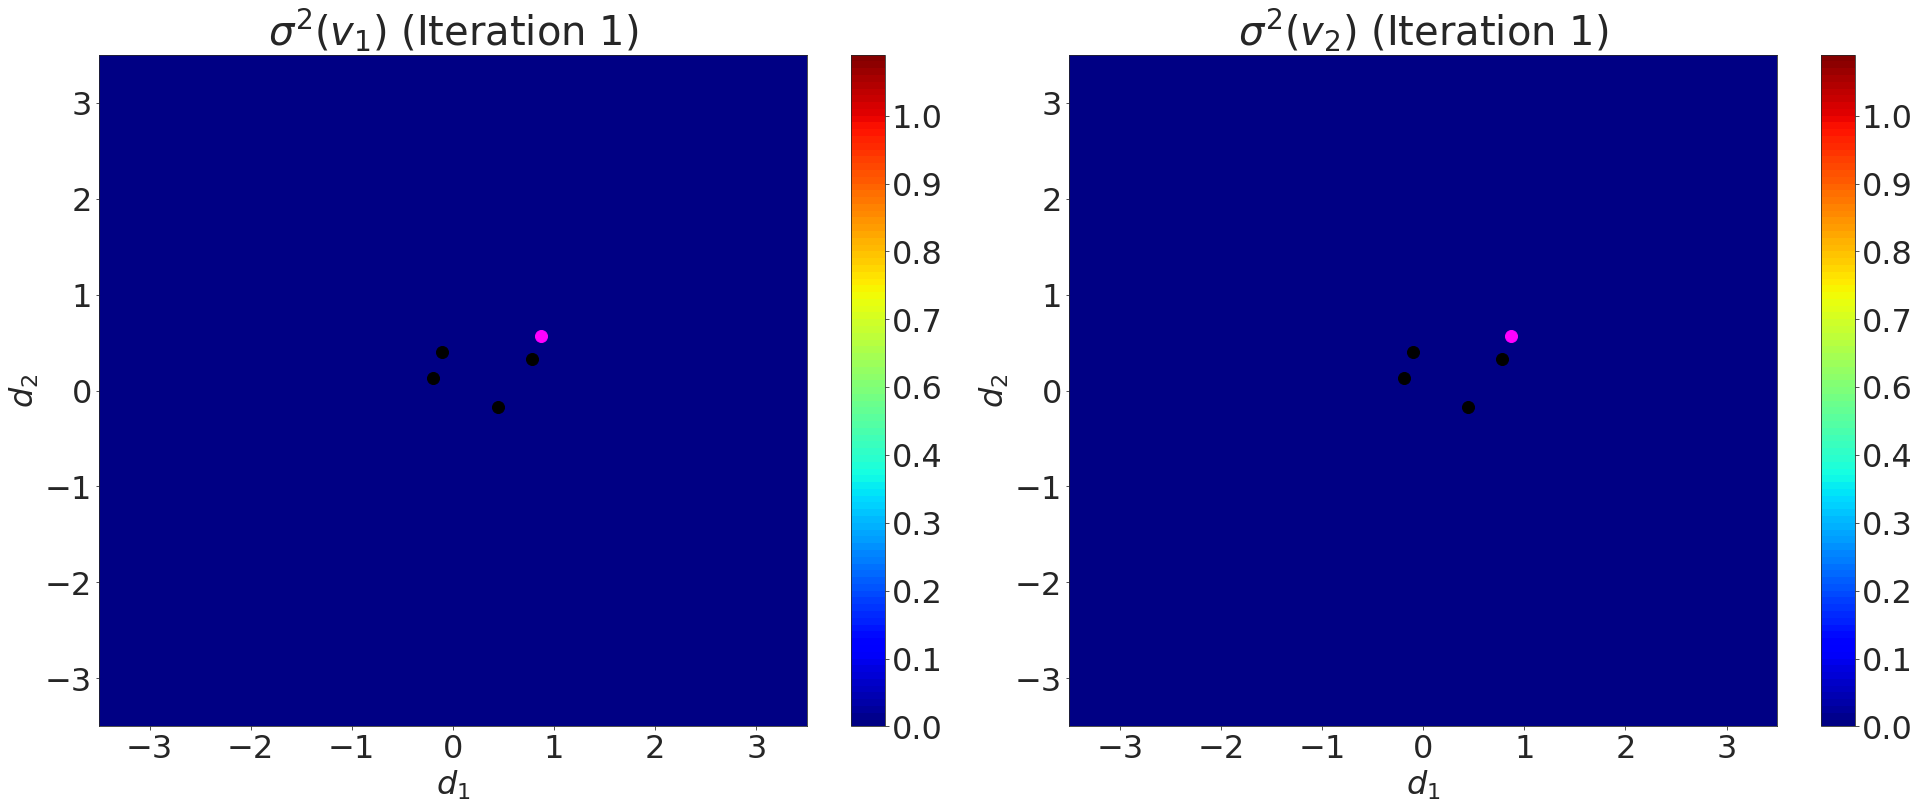

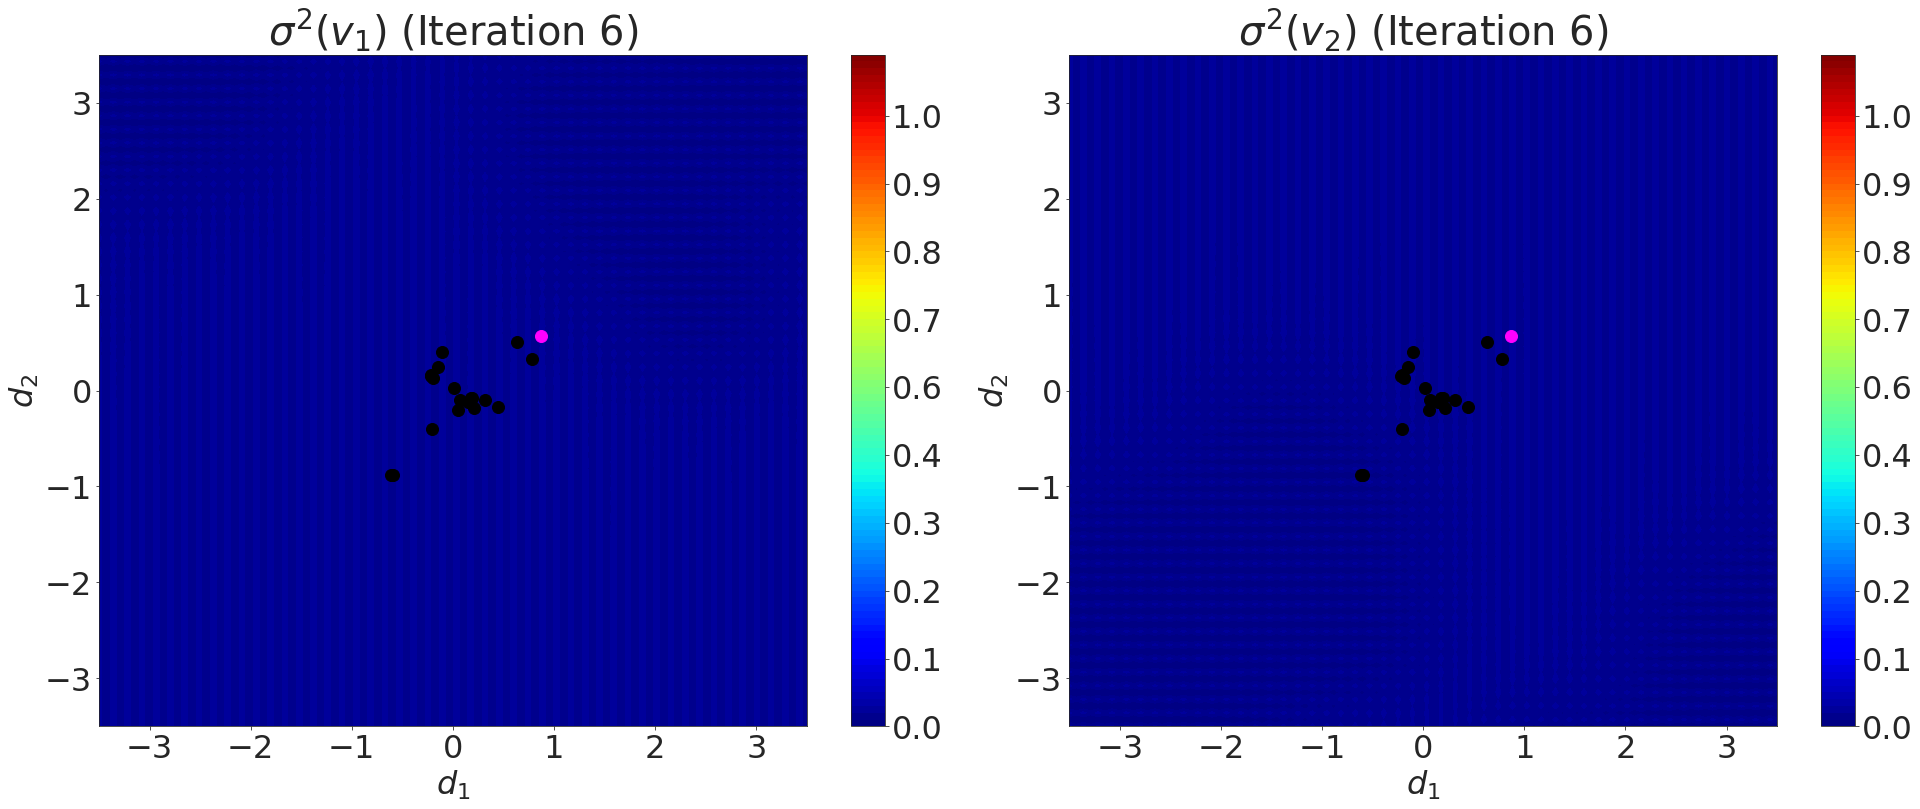

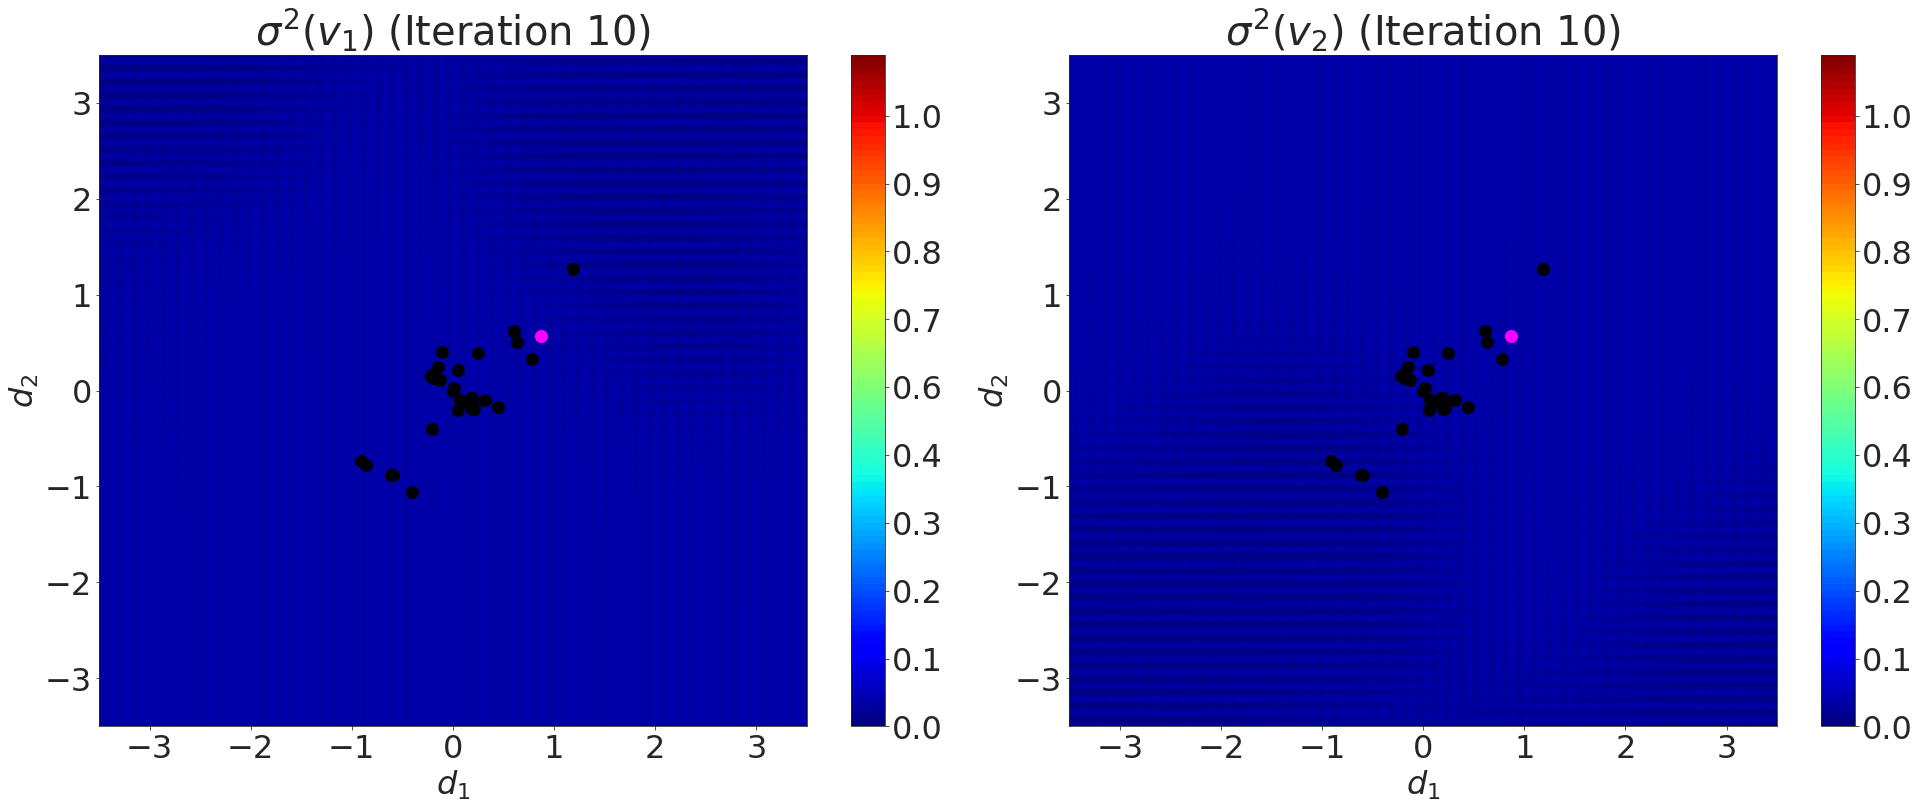

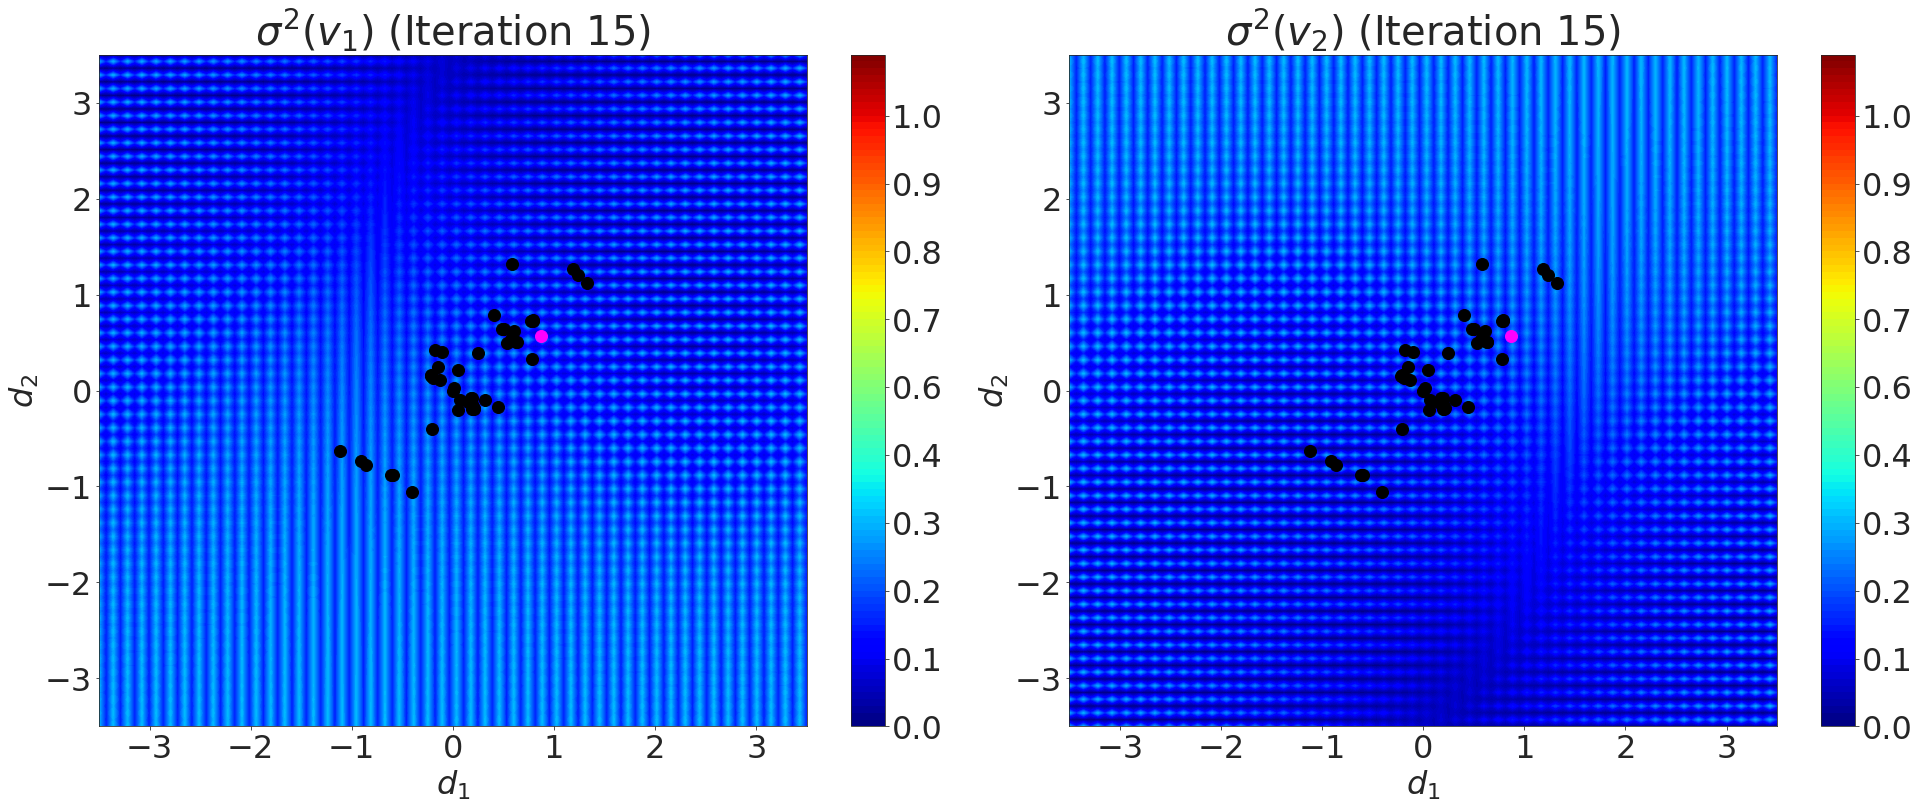

In [29]:
f_target = vf.tgt_vec
f_target = f_target.reshape(f_target.shape[0],1)
vf.tgt_loc = vf.tgt_loc.reshape(2,1)
#x0 = Tensor(np.array([0.1937, 0.1257]))
#x0 = Tensor(np.array([0.1885, 0.1038]))
x_plot = np.linspace(-3.5, 3.5, 100)
y_plot = np.linspace(-3.5, 3.5, 100)
xv_plot, yv_plot = np.meshgrid(x_plot, y_plot)
n = x_plot.shape[0]
x_concat_ = torch.zeros(n * n, 2)

# n_sample = x_concat_.shape[0]
num_tasks = 2
i = 0
k = 0
while i < n*n:
    x_concat_[i:i+n,0] = Tensor(xv_plot[:,k])
    x_concat_[i:i+n,1] = Tensor(y_plot)
    k = k+1
    i = i+n
    

tgt_plot = vfield_(x_concat_)



v_1 = tgt_plot[:,0].reshape(n,n)
v_2 = tgt_plot[:,1].reshape(n,n)
plot = [1, 6, 10, iter+1]

for ii in plot:
    try:
        
        PATH = ".//model_Carlo/model_goodmodel/model_base_"+str(ii - 1)+".pt"
        model_16 = torch.load(PATH)
    except:
        PATH = ".//model_Carlo/model_update/model_base_"+str(ii - 1)+".pt"
        model_16 = torch.load(PATH)
        
    #model_16 = torch.load(PATH)
    model_16.eval()

    likelihood.eval()

    #noise = torch.eye(2 * g_theta1.detach().shape[0]) * noise_value
    #print(x_concat_)
    with torch.no_grad(), gpytorch.settings.fast_pred_var(False):
        model_16 = model_16.cpu()
        pred = GPprediction(model_16)
        pr_mean, cov = pred.GPpred(g_theta1.detach(), agg_data, x_concat_, noise_value)
        #pr = (model(g_theta1.detach())) # likelihood(model(x_concat_), noise = torch.ones(x_concat_.shape) * noise_value)#
        pr_mean = pr_mean.reshape(x_concat_.shape[0], num_tasks)
        mean_v_1 = pr_mean[:,0].reshape(n,n)
        mean_v_2 = pr_mean[:,1].reshape(n,n)
        pred_var = cov.diag().reshape(num_tasks, x_concat_.shape[0]).T

        var_v_1 = pred_var[:,0].reshape(n,n)
        var_v_2 = pred_var[:,1].reshape(n,n)
    #     AA = pr.covariance_matrix.mean(axis=0).reshape(num_tasks, x_concat_.shape[0]).T #.diag() #.reshape(num_tasks, num_tasks * g_theta1.shape[0]).T

    # #     print(pr.covariance_matrix.mean(axis=0))
    # #     print(AA)
    # #     print(pr.variance)
    # #     print((pr.covariance_matrix))
    # #     K = model.covar_module
    #     print((cov.diag()))
    #     print(pr_mean)


    fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (28, 12), tight_layout=True)
    diff_mean_v1= torch.abs(v_1 - mean_v_1.detach())#/torch.abs(v_1)
    minn = torch.min(var_v_1.detach().min(), var_v_2.detach().min())
    maxx = torch.min(var_v_1.detach().max(), var_v_2.detach().max())

    cs11 = ax1.contourf(xv_plot, yv_plot, var_v_1.detach(), np.linspace(0.0,1.1, 100), cmap = 'jet')
    ax1.plot(vf.tgt_loc[0],vf.tgt_loc[1], 'o', color = 'magenta', markersize=12)
    
    ax1.plot(g_theta1[0:(4 + (ii - 1)* 3), 0].detach(),g_theta1[0:(4 + (ii - 1)* 3), 1].detach() , 'o', color = 'black',markersize=12, alpha = 1.0)
  
    ax1.set_title('$\sigma^2(v_1)$ (Iteration '+str(ii)+')', fontsize = 40)
    # ax1[0].set_aspect('equal')
    # ax1[1].set_aspect('equal')
    cbar11 = fig.colorbar(cs11, ax = ax1,format=OOMFormatter(-0, mathText=False));
    ax1.set_xlabel('$d_1$')
    ax1.set_ylabel('$d_2$')


  


    cs21 = ax2.contourf(xv_plot, yv_plot, var_v_2.detach(), np.linspace(0.0, 1.1, 100), cmap = 'jet')
    ax2.plot(g_theta1[0:(4 + (ii - 1)* 3), 0].detach(),g_theta1[0:(4 + (ii - 1)* 3), 1].detach() , 'o', color = 'black',markersize=12, alpha = 1.0)
    ax2.plot(vf.tgt_loc[0],vf.tgt_loc[1], 'o', color = 'magenta', markersize=12)
    ax2.set_title('$\sigma^2(v_2)$ (Iteration '+str(ii)+')', fontsize = 40)
    cbar21 = fig.colorbar(cs21, ax = ax2,format=OOMFormatter(-0, mathText=False));
    ax2.set_xlabel('$d_1$')
    ax2.set_ylabel('$d_2$')


    # ax2[0].set_aspect('equal')
    # ax2[1].set_aspect('equal')

    plt.savefig('figures_Carlo/mean_var/var_iter_base'+str(ii)+'.pdf', dpi=300, bbox_inches='tight')
    plt.show()




In [30]:
# x_plot = np.linspace(-3., 3., 30)
# y_plot = np.linspace(-3., 3., 30)
# xv_plot, yv_plot = np.meshgrid(x_plot, y_plot)
# n = x_plot.shape[0]
# x_concat_ = torch.zeros(n * n, 2)
# training_param_iter = 200

# # n_sample = x_concat_.shape[0]
# num_tasks = 2
# i = 0
# k = 0
# while i < n*n:
#     x_concat_[i:i+n,0] = Tensor(xv_plot[:,k])
#     x_concat_[i:i+n,1] = Tensor(y_plot)
#     k = k+1
#     i = i+n

# # #dis_2sample = MultivariateNormal( loc = x0, covariance_matrix= .01 * torch.eye(2) )
# #                     #loc_size = 4
# # loc_sample = 1./3. * Tensor(high_minus_low  * np.random.random_sample((3,2)) + vf.low) # #dis_2sample.sample((2 + 1,))
# # loc_sample0 = loc_sample.reshape(2 + 1, 2)
# # g2 = loc_sample0 #Tensor(loc_sample) #.detach()
# likelihood.eval()
# model.eval()
# z = torch.zeros(n*n, 1)
# for ii in range(n*n):
#     print(ii)
#     x0 = x_concat_[ii,:].reshape(1,2)
#     dis_2sample = MultivariateNormal( loc = x0, covariance_matrix= .001 * torch.eye(2) )
#                     #loc_size = 4
#     loc_sample = dis_2sample.sample((2 + 1,))
#     loc_sample0 = loc_sample.reshape(2 + 1, 2)
#     g2 = loc_sample0 #Tensor(loc_sample) #.detach()
    
    
    
#     x_d, g_theta2, loss2, pf1, Qf1, Qf12, data_fit, Q21 = conduct_2opt(agg_data,f_target,x0, g_theta1, model, likelihood, noise_value, g2, training_param_iter)
#     z[ii] = loss2
# z = z.reshape(n,n)

In [31]:
# x_plot = np.linspace(-3., 3., 30)
# y_plot = np.linspace(-3., 3., 30)
# xv_plot, yv_plot = np.meshgrid(x_plot, y_plot)
# n = x_plot.shape[0]
# x_concat_ = torch.zeros(n * n, 2)
# training_param_iter = 200

# # n_sample = x_concat_.shape[0]
# num_tasks = 2
# i = 0
# k = 0
# while i < n*n:
#     x_concat_[i:i+n,0] = Tensor(xv_plot[:,k])
#     x_concat_[i:i+n,1] = Tensor(y_plot)
#     k = k+1
#     i = i+n

# #dis_2sample = MultivariateNormal( loc = x0, covariance_matrix= .01 * torch.eye(2) )
#                     #loc_size = 4
# loc_sample = 1./3. * Tensor(high_minus_low  * np.random.random_sample((3,2)) + vf.low) # #dis_2sample.sample((2 + 1,))
# loc_sample0 = loc_sample.reshape(2 + 1, 2)
# g2 = g_theta2.detach() #loc_sample0 #Tensor(loc_sample) #.detach()
# likelihood.eval()
# model.eval()
# plot = [1, 7, 17, 26]
# zz = torch.zeros(n*n, 4)
# kk = 0
# for jj in plot:
#     try:
        
#         PATH = ".//model_Carlo/model_goodmodel/model_"+str(jj - 1)+".pt"
#         model_16 = torch.load(PATH)
#     except:
#         PATH = ".//model_Carlo/model_update/model_"+str(jj - 1)+".pt"
#         model_16 = torch.load(PATH)
#    # model_16 = torch.load(PATH)
#     model_16.eval()

#     likelihood.eval()
#     g2 = v2.detach()[jj - 1 +loc_size+1 : jj - 1 +loc_size+1 +loc_size+1]
#     g_theta1_cur = g_theta1[0:(4 + (jj - 1)* 3)]
#     agg_data_cur = agg_data[0:2 * (4 + (jj - 1)* 3)]
#     print(agg_data_cur.shape)
#     for ii in range(n*n):
#         print(ii)
#         x0 = x_concat_[ii,:].reshape(1,2)
#     #     dis_2sample = MultivariateNormal( loc = x0, covariance_matrix= .001 * torch.eye(2) )
#     #                     #loc_size = 4
#     #     loc_sample = dis_2sample.sample((2 + 1,))
#     #     loc_sample0 = loc_sample.reshape(2 + 1, 2)
#         #g2 = loc_sample0 #Tensor(loc_sample) #.detach()


        
#         loss2_, pf1_, Qf1_, Qf12_, data_fit_, Q21_ = likelihood.get_ell(agg_data_cur,f_target,x0, g_theta1_cur, model_16, likelihood, noise_value, g2)
#         zz[ii, kk] = loss2_
#     kk = kk+1
# zz = zz.reshape(n,n, 4)
# torch.save(zz.detach(), 'data_plots/zz_success.txt')

In [32]:
# #plot = [1, 5, 10, 20]

# for jj in range(4):
#     fig, ax = plt.subplots(figsize = (16,14))
#     #
#     cs = ax.contour(xv_plot, yv_plot,  zz[:,:,jj].detach(), np.linspace( zz[:,:,jj].detach().numpy().min(), zz[:,:,jj].detach().numpy().max(), 1000), cmap = 'jet')
#     cbar = fig.colorbar(cs, ax = ax,format=OOMFormatter(0, mathText=False));
#     ax.plot(vf.tgt_loc[0],vf.tgt_loc[1], 'o', color = 'magenta', markersize=12)
#     kk = plot[jj]
#     if kk < plot[3]:
#         ax.plot(vec_x[kk,0], vec_x[kk,1],'o', color = 'black',markersize=12)
#     if kk == plot[3]:
#         ax.plot(vec_x[- 1,0], vec_x[- 1,1],'o', color = 'black',markersize=12)
#     ax.set_title('TAD Acquisition Function (Iteration '+str(kk)+')', fontsize = 40)
#     ax.set_xlabel('$d_1$')
#     ax.set_ylabel('$d_2$')
    
#     plt.savefig('figures_Carlo/tad_obj'+str(kk)+'.pdf', dpi=300, bbox_inches='tight')

In [33]:
p21_vec_plot

tensor([[0.8609],
        [0.6109],
        [0.0669],
        [0.4187],
        [0.3029],
        [0.4245],
        [0.0562],
        [0.2496],
        [0.0862],
        [0.5788],
        [0.9952],
        [0.6885],
        [0.1817],
        [0.5240]])